# LoRA on MNIST  



Sources:
1. https://arxiv.org/abs/2106.09685 - LoRA paper
2. https://github.com/sunildkumar/lora_from_scratch/blob/main/lora_on_mnist.ipynb - Code we built upon

In [42]:
!pip install lightning

Defaulting to user installation because normal site-packages is not writeable


In [43]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import LearningRateFinder
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from pytorch_lightning import Callback
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

from torchmetrics import Accuracy

import pandas as pd
import seaborn as sn
import math
import matplotlib.pyplot as plt
import time

# set precision to what lightning suggests for this gpu
torch.set_float32_matmul_precision('high')
# make results reproducible
L.seed_everything(42)

Seed set to 42


42

In [44]:
# reserved for constants
PATH_DATASETS = 'mnist'

In [45]:
# Create another dataset called "quantized_mnist" where feature values are rounded to 0 or 255

class QuantizedMNIST(MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Lambda(lambda x: torch.round(x)),
            ]
        )

In [46]:
# Create another dataset called "inversecolor_mnist" where all pixel values are inverted
class InverseColorMNIST(MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Lambda(lambda x: 1 - x),
            ]
        )

# Create another dataset called "inverted_mnist" where all images are rotated by 180 degrees
class InvertedMNIST(MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x.rot90(2, [1, 2])),
            ]
        )

Train an MLP on full MNIST

In [47]:
class LitMNIST(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=512, lr=2e-4, ver='n'):
        """
        'ver' is 'n' for normal mnist, 'q' for quantized mnist
        """
        super().__init__()

        self.version = ver

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.lr = lr

        # Hardcode some dataset specific attributes
        self.class_names = [0,1,2,3,4,5,6,7,8,9]
        self.min_class = min(self.class_names)
        self.num_classes = len(self.class_names)
        self.dims = (1, 28, 28) # the shape of an example (C x W x H)
        channels, width, height = self.dims

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        self.batch_size = 1024

        # Define layers for model
        self.l1 = nn.Linear(channels * width * height, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, self.num_classes)

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()


        # Define metrics
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)


    def forward(self, x):
        # preprocessing
        x = torch.flatten(x,1)

        # layer 1 (input size, hidden size)
        x = self.l1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # layer 2 (hidden size, hidden size)
        x = self.l2(x)
        x = self.relu(x)
        x = self.dropout(x)

        #layer 3 (hidden size, self.num_classes)
        x = self.l3(x)

        # notice that we return the log probabilities here as that is what nll loss expects in the training step
        return F.log_softmax(x, dim=1)

    def common_step(self, batch, batch_idx):
        # define steps all of {train, val, test} will take in one place
        x, y = batch
        # rescale y to be 0 indexed if necessary (like when we start using mnist 5-9)
        if self.min_class != 0:
            y = y - self.min_class

        logits = self(x)
        loss = F.nll_loss(logits, y)
        return x,y, logits, loss



    def training_step(self, batch, batch_idx):
        _, _, _, loss = self.common_step(batch, batch_idx)
        self.log("train_loss", loss, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):

        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        # we'll use adamw to match the paper
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

    # the rest of the class is helper functions/hooks for configuring data/dataloader building
    @staticmethod
    def get_indices(dataset,class_names):
        if isinstance(dataset, torch.utils.data.dataset.Subset):
            targets = torch.tensor([dataset.dataset.targets[i] for i in dataset.indices])
        else:
            targets = dataset.targets


        indices =  []
        for i in range(len(targets)):
            if targets[i] in class_names:
                indices.append(i)
        return indices

    def create_dataloader(self,dataset):
        idx = self.get_indices(dataset, self.class_names)
        loader = DataLoader(dataset,batch_size=self.batch_size, sampler = SubsetRandomSampler(idx), num_workers=16) # Note - this necessarily shuffles the data due to the sampler we are using
        return loader

    def prepare_data(self):
        # download data
        if self.version == 'n':
            MNIST(self.data_dir, train=True, download=True)
            MNIST(self.data_dir, train=False, download=True)
        if self.version == 'q':
            print("Checkpoint-(0)")
            QuantizedMNIST(self.data_dir, train=True, download=True)
            QuantizedMNIST(self.data_dir, train=False, download=True)
        if self.version == 'i':
            print("Checkpoint-(10)")
            InvertedMNIST(self.data_dir, train=True, download=True)
            InvertedMNIST(self.data_dir, train=False, download=True)
        if self.version == 'c':
            print("Checkpoint-(20)")
            InverseColorMNIST(self.data_dir, train=True, download=True)
            InverseColorMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if self.version == 'n':
            if stage == "fit" or stage is None:
                mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
                self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        if self.version == 'q':
            print("Checkpoint-(1)")
            if stage == "fit" or stage is None:
                mnist_full = QuantizedMNIST(self.data_dir, train=True, transform=self.transform)
                self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        if self.version == 'i':
            print("Checkpoint-(11)")
            if stage == "fit" or stage is None:
                mnist_full = InvertedMNIST(self.data_dir, train=True, transform=self.transform)
                self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        if self.version == 'c':
            print("Checkpoint-(21)")
            if stage == "fit" or stage is None:
                mnist_full = InverseColorMNIST(self.data_dir, train=True, transform=self.transform)
                self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])


        # Assign test dataset for use in dataloader(s)
        if self.version == 'n':
            if stage == "test" or stage is None:
                self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)
        if self.version == 'q':
            if stage == "test" or stage is None:
                self.mnist_test = QuantizedMNIST(self.data_dir, train=False, transform=self.transform)
        if self.version == 'i':
            if stage == "test" or stage is None:
                self.mnist_test = InvertedMNIST(self.data_dir, train=False, transform=self.transform)
        if self.version == 'c':
            if stage == "test" or stage is None:
                self.mnist_test = InverseColorMNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return self.create_dataloader(self.mnist_train)

    def val_dataloader(self):
        return self.create_dataloader(self.mnist_val)

    def test_dataloader(self):
        return self.create_dataloader(self.mnist_test)

    def predict(self, x):
        logits = self(x)
        return torch.argmax(logits, dim=1)


In [48]:
model = LitMNIST()
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
669 K     Trainable params
0         Non-trainable params
669 K     Total params
2.679     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 54/54 [00:22<00:00,  2.41it/s, v_num=36, val_loss=0.108, val_acc=0.972]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 54/54 [00:22<00:00,  2.35it/s, v_num=36, val_loss=0.108, val_acc=0.972]


,train_loss,val_acc,val_loss
epoch,,,
0,0.437986,NaN,NaN
0,NaN,0.8936,0.354874
1,0.309283,NaN,NaN
1,NaN,0.9236,0.266200
2,0.239831,NaN,NaN


/home/mrigankp/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


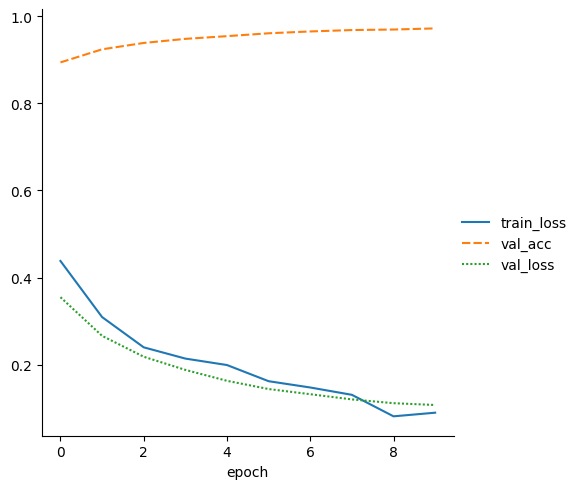

In [49]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [50]:
# as expected our model performs well
trainer.test()

/home/mrigankp/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs/lightning_logs/version_36/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/lightning_logs/version_36/checkpoints/epoch=9-step=540.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 16.29it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9692999720573425     │
│         test_loss         │    0.09711389243602753    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.09711389243602753, 'test_acc': 0.9692999720573425}]

In [51]:
# save model weights so we can finetune from them later
trainer.save_checkpoint("model.ckpt")
torch.save(model.state_dict(), 'model.pt')

# Testing Trained model on  Quantized MNIST, Inverted MNIST and Inverse Color MNIST

In [52]:
# create the dataset
quantized_mnist = QuantizedMNIST(PATH_DATASETS, train=True, download=True)

# create a dataloader
quantized_mnist_loader = DataLoader(quantized_mnist, batch_size=1024, shuffle=False)

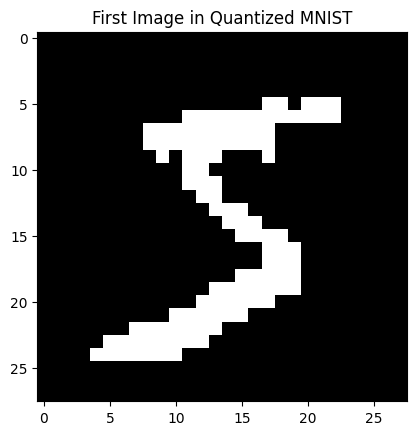

In [53]:
first_image, _ = quantized_mnist[0]  # Access by index (0 for first)

import matplotlib.pyplot as plt

# Rescale the image to be between 0 and 1 (assuming quantization)
first_image = first_image.unsqueeze(0)  # Add a batch dimension for plotting
first_image = first_image * (1.0 / 255)  # Rescale if necessary

# Plot the image
plt.imshow(first_image.squeeze(), cmap="gray")  # Squeeze to remove batch dim
plt.title("First Image in Quantized MNIST")
plt.show()

In [54]:
# test the accuracy of the model on entire quantized dataset
acc = 0
for x, y in quantized_mnist_loader:
    preds = model.predict(x)
    acc += torch.sum(preds == y).item()

acc /= len(quantized_mnist)

print("The accuracy on applying the trained model on Quantized MNIST is ",acc)

The accuracy on applying the trained model on Quantized MNIST is  0.9586833333333333


In [55]:
# create the dataset
inverted_mnist = InvertedMNIST(PATH_DATASETS, train=True, download=True)

# create a dataloader
inverted_mnist_loader = DataLoader(inverted_mnist, batch_size=1024, shuffle=False)

In [56]:
print("Number of images in the inverted MNIST dataset:", len(inverted_mnist))


Number of images in the inverted MNIST dataset: 60000


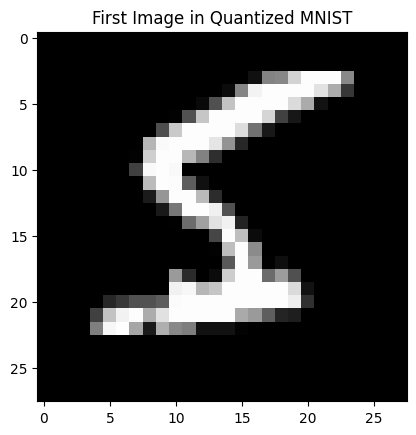

In [57]:
first_image, _ = inverted_mnist[0]  # Access by index (0 for first)
# Rescale the image to be between 0 and 1 (assuming quantization)
first_image = first_image.unsqueeze(0)  # Add a batch dimension for plotting
first_image = first_image * (1.0 / 255)  # Rescale if necessary

# Plot the image
plt.imshow(first_image.squeeze(), cmap="gray")  # Squeeze to remove batch dim
plt.title("First Image in Quantized MNIST")
plt.show()


In [58]:
# test the accuracy of the model on entire quantized dataset
acc = 0
for x, y in inverted_mnist_loader:
    preds = model.predict(x)
    acc += torch.sum(preds == y).item()

acc /= len(inverted_mnist)

print("The accuracy on applying the trained model on Inverted MNIST  is ",acc)

The accuracy on applying the trained model on Inverted MNIST  is  0.20566666666666666


In [59]:
# create the dataset
inverse_color_mnist = InverseColorMNIST(PATH_DATASETS, train=True, download=True)

# create a dataloader
inverse_color_mnistmnist_loader = DataLoader(inverse_color_mnist, batch_size=1024, shuffle=False)

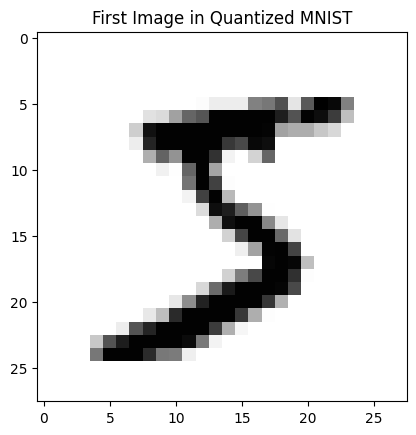

In [60]:
first_image, _ = inverse_color_mnist[0]  # Access by index (0 for first)
# Rescale the image to be between 0 and 1 (assuming quantization)
first_image = first_image.unsqueeze(0)  # Add a batch dimension for plotting
first_image = first_image * (1.0 / 255)  # Rescale if necessary

# Plot the image
plt.imshow(first_image.squeeze(), cmap="gray")  # Squeeze to remove batch dim
plt.title("First Image in Quantized MNIST")
plt.show()

In [61]:
# test the accuracy of the model on entire quantized dataset
acc = 0
for x, y in inverse_color_mnistmnist_loader:
    preds = model.predict(x)
    acc += torch.sum(preds == y).item()

acc /= len(inverse_color_mnist)

print("The accuracy on applying the trained model on Inverse color MNIST  is ",acc)

The accuracy on applying the trained model on Inverse color MNIST  is  0.07241666666666667


# Standard Finetuing on Quantized , Inverted and Inverse color MNIST


In [62]:
# now finetune e2e on the new data (quantized MNIST)
model_quantized = LitMNIST.load_from_checkpoint(checkpoint_path="model.ckpt")
model_quantized.version = 'q'

trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    logger=CSVLogger(save_dir="logs/"),
)
start_time = time.time()
trainer.fit(model_quantized)
result = trainer.test(model=model_quantized)
end_time = time.time()
elapsed_time_quantized_standard_finetuning = end_time - start_time
accuracy_quantized_standard_finetuning = result[0]['test_acc']
print(f"Accuracy on quantized MNIST: {accuracy_quantized_standard_finetuning}")
print(f"Time taken on quantized MNIST: {elapsed_time_quantized_standard_finetuning}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
669 K     Trainable params
0         Non-trainable params
669 K     Total params
2.679     Total estimated model params size (MB)


Checkpoint-(0)
Checkpoint-(1)
Epoch 9: 100%|██████████| 54/54 [00:01<00:00, 52.03it/s, v_num=37, val_loss=0.0731, val_acc=0.976]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 54/54 [00:01<00:00, 51.14it/s, v_num=37, val_loss=0.0731, val_acc=0.976]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Checkpoint-(0)
Checkpoint-(1)
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 357.79it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9735000133514404     │
│         test_loss         │    0.08672214299440384    │
└───────────────────────────┴───────────────────────────┘

Accuracy on quantized MNIST: 0.9735000133514404
Time taken on quantized MNIST: 13.540619611740112


In [63]:
# now finetune e2e on the new data (inverted_MNIST)
model_inverted = LitMNIST.load_from_checkpoint(checkpoint_path="model.ckpt")
model_inverted.version = 'i'

trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    logger=CSVLogger(save_dir="logs/"),
)
start_time = time.time()
trainer.fit(model_inverted)
result = trainer.test(model=model_inverted)
end_time = time.time()
elapsed_time_inverted_standard_finetuning = end_time - start_time
accuracy_inverted_standard_finetuning = result[0]['test_acc']
print(f"Accuracy on inverted MNIST: {accuracy_inverted_standard_finetuning}")
print(f"Time taken on inverted MNIST: {elapsed_time_inverted_standard_finetuning}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Checkpoint-(10)
Checkpoint-(11)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
669 K     Trainable params
0         Non-trainable params
669 K     Total params
2.679     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 54/54 [00:01<00:00, 51.78it/s, v_num=38, val_loss=0.119, val_acc=0.963]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 54/54 [00:01<00:00, 50.89it/s, v_num=38, val_loss=0.119, val_acc=0.963]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Checkpoint-(10)
Checkpoint-(11)
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 197.72it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9685999751091003     │
│         test_loss         │    0.10234721004962921    │
└───────────────────────────┴───────────────────────────┘

Accuracy on inverted MNIST: 0.9685999751091003
Time taken on inverted MNIST: 13.292500734329224


In [64]:
# now finetune e2e on the new data (inverse_color_MNIST)
model_inverse_color = LitMNIST.load_from_checkpoint(checkpoint_path="model.ckpt")
model_inverse_color.version = 'c'

trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    logger=CSVLogger(save_dir="logs/"),
)
start_time = time.time()
trainer.fit(model_inverse_color)
result = trainer.test(model=model_inverse_color)
end_time = time.time()
elapsed_time_inverse_color_standard_finetuning = end_time - start_time
accuracy_inverse_color_standard_finetuning = result[0]['test_acc']
print(f"Accuracy on inverse color MNIST: {accuracy_inverse_color_standard_finetuning}")
print(f"Time taken on inverse color MNIST: {elapsed_time_inverse_color_standard_finetuning}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Checkpoint-(20)
Checkpoint-(21)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
669 K     Trainable params
0         Non-trainable params
669 K     Total params
2.679     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 54/54 [00:01<00:00, 49.40it/s, v_num=39, val_loss=0.158, val_acc=0.949]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 54/54 [00:01<00:00, 48.59it/s, v_num=39, val_loss=0.158, val_acc=0.949]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Checkpoint-(20)
Checkpoint-(21)
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 173.03it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9605000019073486     │
│         test_loss         │    0.13462471961975098    │
└───────────────────────────┴───────────────────────────┘

Accuracy on inverse color MNIST: 0.9605000019073486
Time taken on inverse color MNIST: 13.00852918624878


# Finetune on quantized MNIST using LoRA

In [65]:
# #doesnt have versions
# class LitMNISTLoRA(L.LightningModule):
#     def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, lr=2e-4, lora_rank = 8):
#         super().__init__()

#         # Set our init args as class attributes
#         self.data_dir = data_dir
#         self.hidden_size = hidden_size
#         self.lr = lr

#         # Hardcode some dataset specific attributes
#         self.class_names = [0,1,2,3,4,5,6,7,8,9]
#         self.min_class = min(self.class_names)
#         self.num_classes = len(self.class_names)
#         self.dims = (1, 28, 28) # the shape of an example (C x W x H)
#         channels, width, height = self.dims

#         self.transform = transforms.Compose(
#             [
#                 transforms.ToTensor(),
#                 transforms.Normalize((0.1307,), (0.3081,)),
#             ]
#         )

#         self.batch_size = 1024 # 64

#         # Define layers for model
#         self.l1 = nn.Linear(channels * width * height, hidden_size)
#         self.l2 = nn.Linear(hidden_size, hidden_size)
#         self.l3 = nn.Linear(hidden_size, self.num_classes)

#         self.dropout = nn.Dropout(0.1)
#         self.relu = nn.ReLU()

#         # Define lora hyperparameters
#         self.lora_rank = lora_rank # The rank 'r' for the low-rank adaptation
#         self.lora_alpha = 1 # lora scaling factor

#         # layer 1 lora layers
#         self.l1_lora_A = nn.Parameter(torch.empty(channels * width * height, self.lora_rank))
#         self.l1_lora_B = nn.Parameter(torch.empty(self.lora_rank, hidden_size))

#         # layer 2 lora layers
#         self.l2_lora_A =  nn.Parameter(torch.empty(hidden_size, self.lora_rank))
#         self.l2_lora_B = nn.Parameter(torch.empty(self.lora_rank, hidden_size))

#         # layer 3 lora layers
#         self.l3_lora_A = nn.Parameter(torch.empty(hidden_size, self.lora_rank))
#         self.l3_lora_B = nn.Parameter(torch.empty(self.lora_rank, self.num_classes))

#         # Define initialization for lora layers (this ensures that the model behavior is identital to to the original model prior to finetuning)
#         for n,p in self.named_parameters():
#             if 'lora' in n:
#                 if n[-1]=='A':
#                     nn.init.kaiming_uniform_(p, a=math.sqrt(5))
#                 elif n[-1]=='B':
#                     nn.init.zeros_(p)

#         # freeze non lora weights
#         for n,p in self.named_parameters():
#             if 'lora' not in n:
#                 p.requires_grad = False

#         # Define metrics
#         self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
#         self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)


#     def lora_linear(self, x, layer, lora_A, lora_B):
#         # does the work of combining outputs from normal layer and lora layer for x
#         # notice that h is the sum of two separate operations on x
#         h = layer(x)
#         h += x@(lora_A @ lora_B)*self.lora_alpha
#         return h

#     def forward(self, x):
#         # preprocessing
#         x = torch.flatten(x,1)

#         # layer 1 (input size, hidden size)
#         x = self.lora_linear(x, self.l1, self.l1_lora_A, self.l1_lora_B)
#         x = self.relu(x)
#         x = self.dropout(x)

#         # layer 2 (hidden size, hidden size)
#         x = self.lora_linear(x, self.l2, self.l2_lora_A, self.l2_lora_B)
#         x = self.relu(x)
#         x = self.dropout(x)

#         #layer 3 (hidden size, self.num_classes)
#         x = self.lora_linear(x, self.l3, self.l3_lora_A, self.l3_lora_B)

#         # notice that we return the log probabilities here as that is what nll loss expects in the training step
#         return F.log_softmax(x, dim=1)

#     def common_step(self, batch, batch_idx):
#         # define steps all of {train, val, test} will take in one place
#         x, y = batch
#         # rescale y to be 0 indexed if necessary (like when we start using mnist 5-9)
#         if self.min_class != 0:
#             y = y - self.min_class

#         logits = self(x)
#         loss = F.nll_loss(logits, y)
#         return x,y, logits, loss



#     def training_step(self, batch, batch_idx):
#         _, _, _, loss = self.common_step(batch, batch_idx)
#         self.log("train_loss", loss, batch_size=self.batch_size)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         x, y, logits, loss = self.common_step(batch, batch_idx)
#         preds = torch.argmax(logits, dim=1)
#         self.val_accuracy.update(preds, y)

#         self.log("val_loss", loss, prog_bar=False)
#         self.log("val_acc", self.val_accuracy, prog_bar=True)

#     def test_step(self, batch, batch_idx):
#         x, y, logits, loss = self.common_step(batch, batch_idx)
#         preds = torch.argmax(logits, dim=1)
#         self.test_accuracy.update(preds, y)

#         self.log("test_loss", loss, prog_bar=True)
#         self.log("test_acc", self.test_accuracy, prog_bar=True)

#     def configure_optimizers(self):
#         # we'll use adamw to match the paper
#         optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

#         return {
#         "optimizer": optimizer,
#         "lr_scheduler": {
#             "scheduler": scheduler,
#             "monitor": "val_loss",
#             "frequency": 1
#         },
#         }


#     # the rest of the class is helper functions/hooks for configuring data/dataloader building
#     @staticmethod
#     def get_indices(dataset,class_names):
#         if isinstance(dataset, torch.utils.data.dataset.Subset):
#             targets = torch.tensor([dataset.dataset.targets[i] for i in dataset.indices])
#         else:
#             targets = dataset.targets


#         indices =  []
#         for i in range(len(targets)):
#             if targets[i] in class_names:
#                 indices.append(i)
#         return indices

#     def create_dataloader(self,dataset):
#         idx = self.get_indices(dataset, self.class_names)
#         loader = DataLoader(dataset,batch_size=self.batch_size, sampler = SubsetRandomSampler(idx), num_workers=16) # Note - this necessarily shuffles the data due to the sampler we are using
#         return loader

#     def prepare_data(self):
#         # download data
#         QuantizedMNIST(self.data_dir, train=True, download=True)
#         QuantizedMNIST(self.data_dir, train=False, download=True)

#     def setup(self, stage=None):
#         # Assign train/val datasets for use in dataloaders
#         if stage == "fit" or stage is None:
#             mnist_full = QuantizedMNIST(self.data_dir, train=True, transform=self.transform)
#             self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

#         # Assign test dataset for use in dataloader(s)
#         if stage == "test" or stage is None:
#             self.mnist_test = QuantizedMNIST(self.data_dir, train=False, transform=self.transform)

#     def train_dataloader(self):
#         return self.create_dataloader(self.mnist_train)

#     def val_dataloader(self):
#         return self.create_dataloader(self.mnist_val)

#     def test_dataloader(self):
#         return self.create_dataloader(self.mnist_test)

In [66]:
class LitMNISTLoRA(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=512, lr=2e-4, lora_rank=8, version='n'):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.lr = lr
        
        self.version = version


        # Hardcode some dataset specific attributes
        self.class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        self.min_class = min(self.class_names)
        self.num_classes = len(self.class_names)
        self.dims = (1, 28, 28)  # the shape of an example (C x W x H)
        channels, width, height = self.dims

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        self.batch_size = 1024  # 64

        # Define layers for model
        self.l1 = nn.Linear(channels * width * height, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, self.num_classes)

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

        # Define lora hyperparameters
        self.lora_rank = lora_rank  # The rank 'r' for the low-rank adaptation
        self.lora_alpha = 1  # lora scaling factor

        # layer 1 lora layers
        self.l1_lora_A = nn.Parameter(torch.empty(channels * width * height, self.lora_rank))
        self.l1_lora_B = nn.Parameter(torch.empty(self.lora_rank, hidden_size))

        # layer 2 lora layers
        self.l2_lora_A = nn.Parameter(torch.empty(hidden_size, self.lora_rank))
        self.l2_lora_B = nn.Parameter(torch.empty(self.lora_rank, hidden_size))

        # layer 3 lora layers
        self.l3_lora_A = nn.Parameter(torch.empty(hidden_size, self.lora_rank))
        self.l3_lora_B = nn.Parameter(torch.empty(self.lora_rank, self.num_classes))

        # Define initialization for lora layers (this ensures that the model behavior is identical to the original model prior to finetuning)
        for n, p in self.named_parameters():
            if 'lora' in n:
                if n[-1] == 'A':
                    nn.init.kaiming_uniform_(p, a=math.sqrt(5))
                elif n[-1] == 'B':
                    nn.init.zeros_(p)

        # freeze non lora weights
        for n, p in self.named_parameters():
            if 'lora' not in n:
                p.requires_grad = False

        # Define metrics
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)

    def lora_linear(self, x, layer, lora_A, lora_B):
        # does the work of combining outputs from normal layer and lora layer for x
        # notice that h is the sum of two separate operations on x
        h = layer(x)
        h += x @ (lora_A @ lora_B) * self.lora_alpha
        return h

    def forward(self, x):
        # preprocessing
        x = torch.flatten(x, 1)

        # layer 1 (input size, hidden size)
        x = self.lora_linear(x, self.l1, self.l1_lora_A, self.l1_lora_B)
        x = self.relu(x)
        x = self.dropout(x)

        # layer 2 (hidden size, hidden size)
        x = self.lora_linear(x, self.l2, self.l2_lora_A, self.l2_lora_B)
        x = self.relu(x)
        x = self.dropout(x)

        # layer 3 (hidden size, self.num_classes)
        x = self.lora_linear(x, self.l3, self.l3_lora_A, self.l3_lora_B)

        # notice that we return the log probabilities here as that is what nll loss expects in the training step
        return F.log_softmax(x, dim=1)

    def common_step(self, batch, batch_idx):
        # define steps all of {train, val, test} will take in one place
        x, y = batch
        # rescale y to be 0 indexed if necessary (like when we start using mnist 5-9)
        if self.min_class != 0:
            y = y - self.min_class

        logits = self(x)
        loss = F.nll_loss(logits, y)
        return x, y, logits, loss

    def training_step(self, batch, batch_idx):
        _, _, _, loss = self.common_step(batch, batch_idx)
        self.log("train_loss", loss, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        self.log("val_loss", loss, prog_bar=False)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        # we'll use adamw to match the paper
        print(">>>", list(self.named_parameters()))
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "frequency": 1
            },
        }

    # the rest of the class is helper functions/hooks for configuring data/dataloader building
    @staticmethod
    def get_indices(dataset, class_names):
        if isinstance(dataset, torch.utils.data.dataset.Subset):
            targets = torch.tensor([dataset.dataset.targets[i] for i in dataset.indices])
        else:
            targets = dataset.targets

        indices = []
        for i in range(len(targets)):
            if targets[i] in class_names:
                indices.append(i)
        return indices

    def create_dataloader(self, dataset):
        idx = self.get_indices(dataset, self.class_names)
        loader = DataLoader(dataset, batch_size=self.batch_size, sampler=SubsetRandomSampler(idx),
                            num_workers=16)  # Note - this necessarily shuffles the data due to the sampler we are using
        return loader

    def prepare_data(self):
        # download data based on version
        if self.version == 'n':
            MNIST(self.data_dir, train=True, download=True)
            MNIST(self.data_dir, train=False, download=True)
        elif self.version == 'q':
            QuantizedMNIST(self.data_dir, train=True, download=True)
            QuantizedMNIST(self.data_dir, train=False, download=True)
        elif self.version == 'i':
            InvertedMNIST(self.data_dir, train=True, download=True)
            InvertedMNIST(self.data_dir, train=False, download=True)
        elif self.version == 'c':
            InverseColorMNIST(self.data_dir, train=True, download=True)
            InverseColorMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders based on version
        
        if stage == "fit" or stage is None:
            if self.version == 'n':
                mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            elif self.version == 'q':
                mnist_full = QuantizedMNIST(self.data_dir, train=True, transform=self.transform)
            elif self.version == 'i':
                mnist_full = InvertedMNIST(self.data_dir, train=True, transform=self.transform)
            elif self.version == 'c':
                mnist_full = InverseColorMNIST(self.data_dir, train=True, transform=self.transform)

            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s) based on version
        if stage == "test" or stage is None:
            if self.version == 'n':
                self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)
            elif self.version == 'q':
                self.mnist_test = QuantizedMNIST(self.data_dir, train=False, transform=self.transform)
            elif self.version == 'i':
                self.mnist_test = InvertedMNIST(self.data_dir, train=False, transform=self.transform)
            elif self.version == 'c':
                self.mnist_test = InverseColorMNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return self.create_dataloader(self.mnist_train)

    def val_dataloader(self):
        return self.create_dataloader(self.mnist_val)

    def test_dataloader(self):
        return self.create_dataloader(self.mnist_test)


In [67]:
# try lora finetuning with different lora ranks for all datasets
def lora_experiment(rank, version):
    state_dict = torch.load("model.pt")
    model = LitMNISTLoRA(lora_rank=rank)  # Create an instance of LitMNISTLoRA
    model.setup(stage=None)  # Call setup before setting version
    model.load_state_dict(state_dict, strict=False)
    model.version = version  # Now it should be accessible

    from lightning.pytorch.callbacks import LearningRateMonitor
    lr_monitor = LearningRateMonitor(logging_interval='step')

    trainer = L.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=10,
        callbacks=[lr_monitor, EarlyStopping(monitor="val_loss", mode="min", patience=10)],
        enable_progress_bar=False
    )

    trainer.fit(model)
    return trainer.test()[0]['test_acc']



In [68]:
results_dict = {}

In [69]:
import time

version = 'q'
print(f"\nFine-tuning on {version} MNIST dataset...\n")
print("{:<10} {:<15} {:<15}".format("Rank", "Accuracy", "Time (seconds)"))
print("-" * 40)
version_results_q = {}
for rank in [1, 2, 4, 8, 16, 32, 64]:
    start_time = time.time()
    result = lora_experiment(rank, version)
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Store results in the dictionary
    version_results_q[rank] = {"Accuracy": result, "Time": elapsed_time}

    print("{:<10} {:<15} {:<15.4f}".format(rank, result, elapsed_time))

print("\n")
results_dict[version] = version_results_q
print(version_results_q)



Fine-tuning on q MNIST dataset...

Rank       Accuracy        Time (seconds) 
----------------------------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


>>> 


  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 2.8 K 
-----------------------------------------------------
2.8 K     Trainable params
669 K     Non-trainable params
672 K     Total params
2.690     Total estimated model params size (MB)


[('l1_lora_A', Parameter containing:
tensor([[ 9.2298e-01],
        [ 3.2488e-01],
        [-8.3485e-01],
        [ 9.1876e-01],
        [ 9.9397e-01],
        [-6.3881e-01],
        [ 9.6551e-01],
        [ 2.2760e-01],
        [ 9.8678e-02],
        [-3.3383e-01],
        [ 4.7362e-01],
        [ 7.7601e-01],
        [-5.8443e-02],
        [-9.4608e-01],
        [-9.8066e-01],
        [-3.9596e-01],
        [ 4.9859e-01],
        [ 5.5615e-01],
        [-4.2093e-01],
        [ 3.8943e-01],
        [ 5.7349e-01],
        [-6.8335e-01],
        [ 3.7840e-01],
        [-4.3237e-01],
        [ 1.8679e-01],
        [ 8.5916e-01],
        [-6.3604e-01],
        [ 7.0632e-02],
        [-5.7346e-01],
        [-9.1877e-02],
        [-1.3603e-02],
        [-5.5717e-01],
        [ 7.5878e-01],
        [ 4.2885e-01],
        [-3.0352e-02],
        [-1.7078e-01],
        [-7.9101e-01],
        [-8.4334e-01],
        [ 7.4848e-01],
        [-8.2775e-01],
        [-9.4988e-01],
        [-9.7889e-01

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_178/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_178/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9501000046730042     │
│         test_loss         │     0.293008953332901     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 5.7 K 
-----------------------------------------------------
5.7 K     Trainable params
669 K     Non-trainable params
675 K     Total params
2.702     Total estimated model params size (MB)


1          0.9501000046730042 12.9568        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.6303, -0.2173],
        [ 0.4352,  0.3763],
        [ 0.2681,  0.5122],
        ...,
        [ 0.1135,  0.3811],
        [-0.1285, -0.3455],
        [ 0.4101, -0.6897]], device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.2034,  0.0050],
        [-0.2405, -0.6268],
        [-0.2826, -0.1435],
        ...,
        [ 0.3944,  0.0604],
        [-0.3310, -0.2195],
        [-0.5422,  0.4711]], device='cuda:0', requires_grad=True)), ('l2_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l3_lora_A', Parameter containing:
tensor([[ 0.2454,  0.2078],
        [-0.3047,  0.1022],
        [-0.6811,  0.5825],
   

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_179/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_179/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9520000219345093     │
│         test_loss         │    0.24455375969409943    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 11.4 K
-----------------------------------------------------
11.4 K    Trainable params
669 K     Non-trainable params
681 K     Total params
2.724     Total estimated model params size (MB)


2          0.9520000219345093 14.6836        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.4560,  0.0895, -0.3980,  0.0582],
        [-0.1826,  0.4843,  0.4736, -0.3175],
        [ 0.0529, -0.3133,  0.2829,  0.1311],
        ...,
        [ 0.3964, -0.0130, -0.1108, -0.2327],
        [ 0.2448, -0.1217, -0.0231, -0.0885],
        [ 0.4859,  0.3676, -0.1247, -0.1929]], device='cuda:0',
       requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.1013,  0.4979,  0.4326,  0.1193],
        [-0.4921,  0.2730,  0.4079,  0.4016],
        [-0.4733,  0.1444, -0.3366, -0.4919],
        ...,
        [-0.3001,  0.4072,  0.4578, -0.4774],
        [ 0.0419,  0.1582,  0.1347,  0.3201],
        [-0.2365,  0.2722,  0.0316,  0.0194]], device='cuda:0'

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_180/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_180/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9542999863624573     │
│         test_loss         │    0.19321128726005554    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 22.7 K
-----------------------------------------------------
22.7 K    Trainable params
669 K     Non-trainable params
692 K     Total params
2.770     Total estimated model params size (MB)


4          0.9542999863624573 12.9872        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.0032, -0.1414, -0.1696,  ..., -0.2787, -0.3294,  0.2080],
        [ 0.2152, -0.0472,  0.1354,  ...,  0.1751,  0.0321, -0.2023],
        [ 0.1127, -0.0300,  0.0268,  ...,  0.1469,  0.0853, -0.0834],
        ...,
        [-0.0926, -0.2570, -0.1439,  ...,  0.2673, -0.2270,  0.1197],
        [-0.2138, -0.2833, -0.1774,  ...,  0.0104,  0.1366,  0.0575],
        [-0.0188,  0.0386, -0.2360,  ..., -0.2492, -0.0614,  0.2585]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.2060, -0.1756, -0.2730,  ...,  0.1721, -0.2132,  0.1018]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_181/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_181/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9574000239372253     │
│         test_loss         │    0.1600525975227356     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 45.5 K
-----------------------------------------------------
45.5 K    Trainable params
669 K     Non-trainable params
715 K     Total params
2.861     Total estimated model params size (MB)


8          0.9574000239372253 13.0431        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.2144,  0.1353, -0.2486,  ..., -0.1853,  0.1974, -0.0194],
        [ 0.0402,  0.1305, -0.1416,  ...,  0.1193,  0.2125,  0.2384],
        [-0.1287, -0.1462, -0.1597,  ...,  0.0377,  0.0684, -0.2017],
        ...,
        [-0.0811,  0.0575,  0.0527,  ..., -0.1118, -0.0873,  0.0266],
        [-0.1962, -0.0198, -0.1119,  ...,  0.0667, -0.2299,  0.0385],
        [ 0.0446, -0.1819, -0.2073,  ..., -0.0010,  0.1349, -0.0404]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 4.7685e-02,  2.6898e-02, -1.4494e-01,  ..., -1.1495e-02,
 

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_182/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_182/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9613000154495239     │
│         test_loss         │    0.1378113329410553     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 90.9 K
-----------------------------------------------------
90.9 K    Trainable params
669 K     Non-trainable params
760 K     Total params
3.043     Total estimated model params size (MB)


16         0.9613000154495239 13.1160        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.0338, -0.0180, -0.0479,  ..., -0.1335, -0.1157,  0.1420],
        [-0.1658, -0.0579,  0.0822,  ..., -0.1763, -0.0415,  0.0480],
        [ 0.1488, -0.0923, -0.1092,  ..., -0.1546,  0.1765,  0.0526],
        ...,
        [ 0.1685, -0.1421,  0.0870,  ..., -0.1324, -0.1294,  0.0977],
        [ 0.0864, -0.1056,  0.0101,  ...,  0.1702, -0.0071,  0.0683],
        [-0.1087, -0.0504,  0.0278,  ..., -0.0660,  0.0288,  0.0456]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-9.9765e-02, -1.5652e-01,  6.3018e-02,  ..., -2.5250e-02,
 

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_183/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_183/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9649999737739563     │
│         test_loss         │    0.11805527657270432    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 181 K 
-----------------------------------------------------
181 K     Trainable params
669 K     Non-trainable params
851 K     Total params
3.406     Total estimated model params size (MB)


32         0.9649999737739563 12.9981        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.0268, -0.1187,  0.0036,  ..., -0.0897, -0.1073, -0.0865],
        [ 0.0033, -0.0372,  0.0507,  ...,  0.0857,  0.0348,  0.0324],
        [ 0.0756,  0.1174,  0.0885,  ..., -0.0768, -0.1100, -0.1002],
        ...,
        [-0.1001,  0.0889,  0.0169,  ..., -0.0150, -0.0996, -0.0207],
        [ 0.1212, -0.0138,  0.0133,  ..., -0.0442,  0.0254,  0.0062],
        [-0.1193, -0.1248, -0.0943,  ...,  0.1177,  0.0071, -0.1100]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.1134,  0.0634, -0.0266,  ..., -0.0200, -0.1189, -0.0257]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_184/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_184/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9692999720573425     │
│         test_loss         │    0.10494296997785568    │
└───────────────────────────┴───────────────────────────┘

64         0.9692999720573425 13.2352        


{1: {'Accuracy': 0.9501000046730042, 'Time': 12.956777334213257}, 2: {'Accuracy': 0.9520000219345093, 'Time': 14.683562994003296}, 4: {'Accuracy': 0.9542999863624573, 'Time': 12.987201690673828}, 8: {'Accuracy': 0.9574000239372253, 'Time': 13.043139696121216}, 16: {'Accuracy': 0.9613000154495239, 'Time': 13.11603569984436}, 32: {'Accuracy': 0.9649999737739563, 'Time': 12.998063087463379}, 64: {'Accuracy': 0.9692999720573425, 'Time': 13.23515272140503}}


In [70]:
version = 'i'
print(f"\nFine-tuning on {version} MNIST dataset...\n")
print("{:<10} {:<15} {:<15}".format("Rank", "Accuracy", "Time (seconds)"))
print("-" * 40)

version_results_i = {}

for rank in [1, 2, 4, 8, 16, 32, 64]:
    start_time = time.time()
    result = lora_experiment(rank, version)
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Store results in the dictionary
    version_results_i[rank] = {"Accuracy": result, "Time": elapsed_time}

    print("{:<10} {:<15} {:<15.4f}".format(rank, result, elapsed_time))

print("\n")
results_dict[version] = version_results_i
print(version_results_i)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 2.8 K 
-----------------------------------------------------
2.8 K     Trainable params
669 K     Non-trainable params
672 K     Total params
2.690     Total estimated model params size (MB)



Fine-tuning on i MNIST dataset...

Rank       Accuracy        Time (seconds) 
----------------------------------------
>>> [('l1_lora_A', Parameter containing:
tensor([[-6.5210e-01],
        [-1.5522e-01],
        [ 4.8482e-01],
        [-9.9959e-01],
        [ 9.5778e-01],
        [ 9.2763e-01],
        [ 2.8095e-01],
        [-9.9848e-01],
        [ 2.4818e-01],
        [ 4.0962e-01],
        [ 6.1288e-01],
        [ 5.9355e-01],
        [ 2.1825e-01],
        [ 9.0100e-01],
        [-8.2331e-01],
        [ 8.1727e-01],
        [-9.6927e-02],
        [-7.5649e-01],
        [-4.7345e-01],
        [-3.5260e-01],
        [-7.3844e-01],
        [-4.0220e-02],
        [-3.8453e-03],
        [ 9.2948e-01],
        [ 2.3693e-01],
        [-6.1805e-01],
        [-2.0778e-01],
        [-1.2483e-01],
        [ 1.1221e-01],
        [ 4.0987e-01],
        [ 8.9148e-01],
        [-5.1095e-01],
        [-8.6776e-01],
        [ 8.5059e-01],
        [ 7.8002e-01],
        [-2.0124e-01],
        [-7

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_185/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_185/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6442999839782715     │
│         test_loss         │    1.1479939222335815     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 5.7 K 
-----------------------------------------------------
5.7 K     Trainable params
669 K     Non-trainable params
675 K     Total params
2.702     Total estimated model params size (MB)


1          0.6442999839782715 13.2094        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.2921,  0.5747],
        [ 0.1356, -0.0722],
        [ 0.2240,  0.6508],
        ...,
        [ 0.4684,  0.4912],
        [-0.0728, -0.1591],
        [-0.5886, -0.0912]], device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.6752,  0.1993],
        [ 0.3297,  0.0010],
        [-0.0158,  0.3541],
        ...,
        [ 0.5740, -0.2464],
        [ 0.3074,  0.5212],
        [-0.6130, -0.4548]], device='cuda:0', requires_grad=True)), ('l2_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l3_lora_A', Parameter containing:
tensor([[ 0.4439,  0.1329],
        [-0.4563, -0.0345],
        [-0.1260,  0.5294],
   

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_186/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_186/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8199999928474426     │
│         test_loss         │    0.6215330958366394     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 11.4 K
-----------------------------------------------------
11.4 K    Trainable params
669 K     Non-trainable params
681 K     Total params
2.724     Total estimated model params size (MB)


2          0.8199999928474426 13.9890        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.2350,  0.3030,  0.2052,  0.3016],
        [-0.3049, -0.1169, -0.4780, -0.4439],
        [-0.4376,  0.1236,  0.2272, -0.4736],
        ...,
        [-0.1585,  0.4889, -0.0024,  0.4528],
        [-0.0187,  0.4060,  0.1652,  0.3487],
        [ 0.3356,  0.1432, -0.1393,  0.0366]], device='cuda:0',
       requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.0325,  0.4428,  0.1653,  0.0257],
        [-0.4981,  0.1262, -0.1387,  0.2561],
        [-0.1912,  0.4930, -0.4582,  0.3150],
        ...,
        [ 0.3343,  0.4656, -0.3152, -0.4940],
        [ 0.2905,  0.1167, -0.0859, -0.4561],
        [ 0.4768, -0.4387,  0.1020, -0.0777]], device='cuda:0'

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_187/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_187/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8841999769210815     │
│         test_loss         │    0.40593865513801575    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 22.7 K
-----------------------------------------------------
22.7 K    Trainable params
669 K     Non-trainable params
692 K     Total params
2.770     Total estimated model params size (MB)


4          0.8841999769210815 13.3489        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.1688, -0.0786, -0.1477,  ..., -0.2445,  0.2209,  0.3518],
        [ 0.0608,  0.0678,  0.3420,  ...,  0.2843,  0.1562, -0.3201],
        [ 0.0358, -0.1212,  0.1750,  ..., -0.0728,  0.3416, -0.1871],
        ...,
        [ 0.0942, -0.2357, -0.3358,  ...,  0.1561, -0.0648,  0.2663],
        [ 0.1933, -0.2950,  0.2232,  ...,  0.3501,  0.1943,  0.1882],
        [ 0.1794, -0.2250, -0.3085,  ..., -0.2381, -0.0529, -0.1188]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.3259,  0.1283, -0.3082,  ...,  0.2494,  0.0035, -0.1564]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_188/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_188/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9061999917030334     │
│         test_loss         │    0.31045103073120117    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 45.5 K
-----------------------------------------------------
45.5 K    Trainable params
669 K     Non-trainable params
715 K     Total params
2.861     Total estimated model params size (MB)


8          0.9061999917030334 13.6395        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.0260,  0.1797,  0.2081,  ..., -0.1015,  0.2098, -0.1463],
        [-0.2332, -0.0626, -0.0905,  ..., -0.1361,  0.2090, -0.0404],
        [-0.1663, -0.2426,  0.0710,  ..., -0.1979,  0.0119,  0.2117],
        ...,
        [ 0.0186,  0.2101, -0.1693,  ..., -0.1311,  0.1943,  0.1326],
        [-0.1918, -0.0050, -0.2118,  ...,  0.2380, -0.0762, -0.2434],
        [ 0.2184, -0.0092, -0.1938,  ...,  0.0031, -0.0234, -0.0701]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.2195, -0.1404, -0.0236,  ...,  0.1681, -0.1283,  0.0625]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_189/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_189/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9294000267982483     │
│         test_loss         │    0.2332276850938797     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 90.9 K
-----------------------------------------------------
90.9 K    Trainable params
669 K     Non-trainable params
760 K     Total params
3.043     Total estimated model params size (MB)


16         0.9294000267982483 13.0918        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.0505,  0.0442,  0.0367,  ..., -0.1652,  0.1382,  0.0144],
        [ 0.1237, -0.1402, -0.0206,  ...,  0.1444,  0.0477, -0.0423],
        [-0.0672, -0.1065, -0.0163,  ..., -0.0077,  0.0534, -0.1560],
        ...,
        [ 0.1273, -0.0677,  0.0722,  ..., -0.1393,  0.0229,  0.0358],
        [ 0.0985,  0.1369, -0.1097,  ..., -0.1174,  0.0072,  0.0718],
        [-0.1140,  0.0462, -0.0662,  ...,  0.0238,  0.0111,  0.1015]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.1048,  0.0871, -0.0236,  ..., -0.0754,  0.0076, -0.0434]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_190/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_190/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9444000124931335     │
│         test_loss         │    0.1862226128578186     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 181 K 
-----------------------------------------------------
181 K     Trainable params
669 K     Non-trainable params
851 K     Total params
3.406     Total estimated model params size (MB)


32         0.9444000124931335 14.0386        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.0655,  0.0567, -0.1066,  ...,  0.0570,  0.1084, -0.0559],
        [ 0.0834,  0.0665,  0.1101,  ...,  0.0392, -0.0574, -0.0500],
        [ 0.1239,  0.0468, -0.0222,  ..., -0.0170,  0.1241,  0.1012],
        ...,
        [-0.1116, -0.1181, -0.0387,  ..., -0.1057,  0.0145,  0.1162],
        [-0.0847,  0.1125, -0.1224,  ..., -0.0963,  0.0821,  0.0400],
        [ 0.0795,  0.1039, -0.0229,  ...,  0.0251,  0.1152,  0.0936]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.0247, -0.0090,  0.0270,  ..., -0.0353,  0.1028, -0.0938]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_191/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_191/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9528999924659729     │
│         test_loss         │    0.15170924365520477    │
└───────────────────────────┴───────────────────────────┘

64         0.9528999924659729 13.0855        


{1: {'Accuracy': 0.6442999839782715, 'Time': 13.20941948890686}, 2: {'Accuracy': 0.8199999928474426, 'Time': 13.989012002944946}, 4: {'Accuracy': 0.8841999769210815, 'Time': 13.348866701126099}, 8: {'Accuracy': 0.9061999917030334, 'Time': 13.639500617980957}, 16: {'Accuracy': 0.9294000267982483, 'Time': 13.09181523323059}, 32: {'Accuracy': 0.9444000124931335, 'Time': 14.038610458374023}, 64: {'Accuracy': 0.9528999924659729, 'Time': 13.085457563400269}}


In [71]:
print(version_results_i)

{1: {'Accuracy': 0.6442999839782715, 'Time': 13.20941948890686}, 2: {'Accuracy': 0.8199999928474426, 'Time': 13.989012002944946}, 4: {'Accuracy': 0.8841999769210815, 'Time': 13.348866701126099}, 8: {'Accuracy': 0.9061999917030334, 'Time': 13.639500617980957}, 16: {'Accuracy': 0.9294000267982483, 'Time': 13.09181523323059}, 32: {'Accuracy': 0.9444000124931335, 'Time': 14.038610458374023}, 64: {'Accuracy': 0.9528999924659729, 'Time': 13.085457563400269}}


In [72]:
version = 'c'
print(f"\nFine-tuning on {version} MNIST dataset...\n")
print("{:<10} {:<15} {:<15}".format("Rank", "Accuracy", "Time (seconds)"))
print("-" * 40)

version_results_c = {}

for rank in [1, 2, 4, 8, 16, 32, 64]:
    start_time = time.time()
    result = lora_experiment(rank, version)
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Store results in the dictionary
    version_results_c[rank] = {"Accuracy": result, "Time": elapsed_time}

    print("{:<10} {:<15} {:<15.4f}".format(rank, result, elapsed_time))

print("\n")

results_dict[version] = version_results_c
print(version_results_c)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 2.8 K 
-----------------------------------------------------
2.8 K     Trainable params
669 K     Non-trainable params
672 K     Total params
2.690     Total estimated model params size (MB)



Fine-tuning on c MNIST dataset...

Rank       Accuracy        Time (seconds) 
----------------------------------------
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.4438],
        [ 0.2991],
        [-0.6356],
        [ 0.0980],
        [ 0.0580],
        [ 0.3875],
        [ 0.3410],
        [-0.3424],
        [ 0.1339],
        [ 0.0529],
        [ 0.5308],
        [ 0.5028],
        [ 0.3035],
        [-0.2633],
        [-0.8034],
        [ 0.5815],
        [-0.4863],
        [ 0.3799],
        [ 0.8610],
        [-0.4365],
        [-0.7071],
        [ 0.7881],
        [-0.7720],
        [-0.7420],
        [-0.6305],
        [ 0.8562],
        [ 0.3098],
        [-0.4645],
        [ 0.8677],
        [ 0.9860],
        [ 0.4047],
        [ 0.4826],
        [-0.6940],
        [ 0.0718],
        [ 0.0272],
        [-0.3823],
        [ 0.5665],
        [ 0.0759],
        [ 0.2209],
        [-0.2432],
        [ 0.8901],
        [-0.3363],
        [-0.0165],
        [-0.5321],
   

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_192/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_192/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3452000021934509     │
│         test_loss         │    1.7071713209152222     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 5.7 K 
-----------------------------------------------------
5.7 K     Trainable params
669 K     Non-trainable params
675 K     Total params
2.702     Total estimated model params size (MB)


1          0.3452000021934509 13.0008        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.3405,  0.2578],
        [ 0.4367,  0.1054],
        [ 0.4325,  0.2463],
        ...,
        [-0.0891,  0.4610],
        [-0.2521, -0.2668],
        [ 0.1910,  0.1930]], device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.0395, -0.4134],
        [-0.5964, -0.2201],
        [-0.2537, -0.1268],
        ...,
        [-0.3224,  0.5104],
        [-0.3708,  0.3807],
        [-0.0789,  0.5823]], device='cuda:0', requires_grad=True)), ('l2_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l3_lora_A', Parameter containing:
tensor([[-0.4316,  0.5640],
        [ 0.2251,  0.3183],
        [ 0.6041,  0.6455],
   

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_193/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_193/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6331999897956848     │
│         test_loss         │    1.1696406602859497     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 11.4 K
-----------------------------------------------------
11.4 K    Trainable params
669 K     Non-trainable params
681 K     Total params
2.724     Total estimated model params size (MB)


2          0.6331999897956848 13.1006        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.2238,  0.1846, -0.2451,  0.3379],
        [-0.4588, -0.2647,  0.0613,  0.2313],
        [-0.2546, -0.4753, -0.0687, -0.4546],
        ...,
        [-0.2257, -0.0743,  0.2186, -0.3063],
        [-0.2880, -0.1916,  0.3243,  0.4493],
        [-0.1970,  0.3900,  0.3287, -0.2934]], device='cuda:0',
       requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.2877, -0.3571, -0.0640, -0.2001],
        [ 0.1679,  0.4867,  0.0325,  0.1918],
        [-0.1285, -0.4547, -0.4351,  0.4118],
        ...,
        [-0.4377,  0.1818, -0.3628, -0.1212],
        [ 0.2182, -0.0516, -0.1785,  0.4351],
        [ 0.2995, -0.1298, -0.3362, -0.3997]], device='cuda:0'

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_194/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_194/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8133000135421753     │
│         test_loss         │    0.6211615800857544     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 22.7 K
-----------------------------------------------------
22.7 K    Trainable params
669 K     Non-trainable params
692 K     Total params
2.770     Total estimated model params size (MB)


4          0.8133000135421753 12.9283        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.0856, -0.3304, -0.0702,  ..., -0.1413, -0.1173,  0.2265],
        [-0.2246,  0.1420, -0.2004,  ...,  0.2008, -0.0211,  0.2560],
        [ 0.1740, -0.0543,  0.2842,  ...,  0.2807,  0.0335, -0.1206],
        ...,
        [-0.1269,  0.3491, -0.0577,  ...,  0.3203, -0.1857, -0.2294],
        [-0.0339,  0.1762,  0.2534,  ...,  0.0472, -0.2777, -0.3064],
        [ 0.1628, -0.1256, -0.2557,  ...,  0.2176,  0.0635,  0.1513]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.2832,  0.1212,  0.1467,  ...,  0.3521, -0.0544, -0.1780]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_195/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_195/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8878999948501587     │
│         test_loss         │    0.41001439094543457    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 45.5 K
-----------------------------------------------------
45.5 K    Trainable params
669 K     Non-trainable params
715 K     Total params
2.861     Total estimated model params size (MB)


8          0.8878999948501587 13.1128        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.0250, -0.1197, -0.0020,  ...,  0.0350,  0.1323, -0.1647],
        [-0.0412, -0.0919,  0.0372,  ..., -0.0098,  0.1037,  0.0115],
        [ 0.2324, -0.2204, -0.1311,  ..., -0.1214,  0.0131, -0.0313],
        ...,
        [-0.0827, -0.0990, -0.1809,  ...,  0.0167,  0.1934,  0.1181],
        [ 0.2245, -0.0618, -0.0909,  ...,  0.1305,  0.2316,  0.1450],
        [ 0.0347, -0.0372,  0.2225,  ..., -0.1864, -0.0459,  0.0262]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.1090, -0.1239, -0.0750,  ...,  0.2473,  0.2038,  0.1880]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_196/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_196/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9142000079154968     │
│         test_loss         │    0.2984295189380646     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 90.9 K
-----------------------------------------------------
90.9 K    Trainable params
669 K     Non-trainable params
760 K     Total params
3.043     Total estimated model params size (MB)


16         0.9142000079154968 13.3201        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.0760, -0.1352,  0.1423,  ...,  0.0364,  0.0475,  0.0071],
        [-0.0059,  0.0667, -0.0553,  ..., -0.1110, -0.0994,  0.1335],
        [ 0.0132, -0.0077, -0.1191,  ...,  0.1167,  0.1731, -0.0569],
        ...,
        [-0.1405, -0.1015, -0.1536,  ..., -0.0621, -0.0665, -0.1248],
        [-0.0605, -0.0469,  0.1224,  ...,  0.0348,  0.0490, -0.1125],
        [-0.1202, -0.0517,  0.0281,  ...,  0.0126, -0.0328, -0.0879]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.1017, -0.1753, -0.0371,  ...,  0.0742,  0.1093, -0.0328]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_197/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_197/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9417999982833862     │
│         test_loss         │    0.19869615137577057    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 181 K 
-----------------------------------------------------
181 K     Trainable params
669 K     Non-trainable params
851 K     Total params
3.406     Total estimated model params size (MB)


32         0.9417999982833862 14.2000        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.1130, -0.0422,  0.0457,  ...,  0.1020,  0.0606,  0.0759],
        [-0.0462, -0.0626,  0.0484,  ...,  0.1121,  0.0208, -0.0184],
        [-0.1027,  0.0730,  0.0846,  ...,  0.0472, -0.0707,  0.1219],
        ...,
        [ 0.0206, -0.0953, -0.0821,  ..., -0.0083, -0.1126,  0.0245],
        [ 0.0846,  0.0853, -0.1176,  ..., -0.0168,  0.0387,  0.0108],
        [ 0.0102,  0.0426, -0.1244,  ..., -0.1101, -0.0959,  0.0196]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.0602, -0.0955,  0.0030,  ...,  0.0780,  0.0872,  0.0106]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_198/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_198/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9513000249862671     │
│         test_loss         │    0.16323108971118927    │
└───────────────────────────┴───────────────────────────┘

64         0.9513000249862671 13.1286        


{1: {'Accuracy': 0.3452000021934509, 'Time': 13.000786304473877}, 2: {'Accuracy': 0.6331999897956848, 'Time': 13.100643634796143}, 4: {'Accuracy': 0.8133000135421753, 'Time': 12.928274154663086}, 8: {'Accuracy': 0.8878999948501587, 'Time': 13.112767219543457}, 16: {'Accuracy': 0.9142000079154968, 'Time': 13.320115804672241}, 32: {'Accuracy': 0.9417999982833862, 'Time': 14.19997787475586}, 64: {'Accuracy': 0.9513000249862671, 'Time': 13.12856388092041}}


In [73]:
version_results_c

{1: {'Accuracy': 0.3452000021934509, 'Time': 13.000786304473877},
 2: {'Accuracy': 0.6331999897956848, 'Time': 13.100643634796143},
 4: {'Accuracy': 0.8133000135421753, 'Time': 12.928274154663086},
 8: {'Accuracy': 0.8878999948501587, 'Time': 13.112767219543457},
 16: {'Accuracy': 0.9142000079154968, 'Time': 13.320115804672241},
 32: {'Accuracy': 0.9417999982833862, 'Time': 14.19997787475586},
 64: {'Accuracy': 0.9513000249862671, 'Time': 13.12856388092041}}

In [74]:
# try lora finetuning with different lora ranks
# def lora_experiment(rank):
#     state_dict = torch.load("model.pt")
#     model = LitMNISTLoRA(lora_rank=rank,)
#     model.load_state_dict(state_dict, strict=False)

#     from lightning.pytorch.callbacks import LearningRateMonitor
#     lr_monitor = LearningRateMonitor(logging_interval='step')

#     trainer = L.Trainer(
#         accelerator="auto",
#         devices=1,
#         max_epochs=10,
#         callbacks=[lr_monitor, EarlyStopping(monitor="val_loss", mode="min", patience=10)],

#         enable_progress_bar=False
#     )

#     trainer.fit(model)
#     return trainer.test()[0]['test_acc']



In [75]:
# import time

# results = {}
# for rank in [1, 2, 4, 8, 16, 32, 64]:
#     start_time = time.time()
#     result = lora_experiment(rank)
#     end_time = time.time()
#     elapsed_time = end_time - start_time

#     results[rank] = (result, elapsed_time)  # Store both accuracy and time
#     print(f"Rank {rank} Accuracy: {result}, Time: {elapsed_time:.4f} seconds")

In [76]:
# # try lora finetuning with different lora ranks
# def lora_experiment_inverted(rank):
#     state_dict = torch.load("model.pt")
#     model = LitMNISTLoRA_Inverted(lora_rank=rank,)
#     model.load_state_dict(state_dict, strict=False)

#     from lightning.pytorch.callbacks import LearningRateMonitor
#     lr_monitor = LearningRateMonitor(logging_interval='step')

#     trainer = L.Trainer(
#         accelerator="auto",
#         devices=1,
#         max_epochs=10,
#         callbacks=[lr_monitor, EarlyStopping(monitor="val_loss", mode="min", patience=10)],

#         enable_progress_bar=False
#     )

#     trainer.fit(model)
#     return trainer.test()[0]['test_acc']

In [77]:
# import time

# results = {}
# for rank in [1, 2, 4, 8, 16, 32, 64]:
#     start_time = time.time()
#     result = lora_experiment_inverted(rank)
#     end_time = time.time()
#     elapsed_time = end_time - start_time

#     results[rank] = (result, elapsed_time)  # Store both accuracy and time
#     print(f"Rank {rank} Accuracy: {result}, Time: {elapsed_time:.4f} seconds")

In [78]:
# results

In [79]:
# test the accuracy of the model on original mnist dataset
# create the dataset
og_mnist = QuantizedMNIST(PATH_DATASETS, train=True, download=True)

# create a dataloader
og_mnist_loader = DataLoader(og_mnist, batch_size=1024, shuffle=False)

acc = 0
for x, y in og_mnist_loader:
    preds = model_inverted.predict(x)
    acc += torch.sum(preds == y).item()

acc /= len(og_mnist)

print(acc)

0.3087


# Full Training with LoRA

In [80]:
# try lora full training with different lora ranks
def lora_experiment_fulltrain(rank, version):
    model = LitMNISTLoRA(lora_rank=rank)  # Create an instance of LitMNISTLoRA
    model.setup(stage=None)  # Call setup before setting version

    from lightning.pytorch.callbacks import LearningRateMonitor
    lr_monitor = LearningRateMonitor(logging_interval='step')

    trainer = L.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=10,
        callbacks=[lr_monitor, EarlyStopping(monitor="val_loss", mode="min", patience=10)],
        enable_progress_bar=False
    )

    trainer.fit(model)
    return trainer.test()[0]['test_acc']



In [81]:
full_train_results_dict={}

In [82]:
version = 'q'
print(f"\nFine-tuning on {version} MNIST dataset...\n")
print("{:<10} {:<15} {:<15}".format("Rank", "Accuracy", "Time (seconds)"))
print("-" * 40)

full_train_version_results_q = {}

for rank in [1, 2, 4, 8, 16, 32, 64]:
    start_time = time.time()
    result = lora_experiment_fulltrain(rank, version)
    end_time = time.time()
    elapsed_time = end_time - start_time

    full_train_version_results_q[rank] = {"Accuracy": result, "Time": elapsed_time}

    print("{:<10} {:<15} {:<15.4f}".format(rank, result, elapsed_time))

print("\n")

full_train_results_dict[version] = full_train_version_results_q
print(full_train_version_results_q)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 2.8 K 
-----------------------------------------------------
2.8 K     Trainable params
669 K     Non-trainable params
672 K     Total params
2.690     Total estimated model params size (MB)



Fine-tuning on q MNIST dataset...

Rank       Accuracy        Time (seconds) 
----------------------------------------
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.3847],
        [-0.4586],
        [-0.9246],
        [ 0.5006],
        [ 0.6962],
        [-0.3003],
        [ 0.7668],
        [ 0.1016],
        [-0.4361],
        [-0.7294],
        [-0.0531],
        [ 0.1231],
        [ 0.6367],
        [ 0.4002],
        [ 0.3077],
        [ 0.6468],
        [-0.6277],
        [-0.6379],
        [ 0.2289],
        [-0.9206],
        [-0.4525],
        [-0.1558],
        [ 0.0041],
        [-0.7377],
        [-0.2039],
        [ 0.5284],
        [-0.8314],
        [-0.1568],
        [ 0.5712],
        [ 0.4779],
        [-0.4373],
        [ 0.6450],
        [-0.3161],
        [ 0.8409],
        [ 0.1018],
        [-0.3544],
        [ 0.8134],
        [-0.6332],
        [ 0.7266],
        [-0.6557],
        [ 0.1396],
        [-0.6592],
        [ 0.7123],
        [-0.9137],
   

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_199/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_199/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5252000093460083     │
│         test_loss         │    1.3857320547103882     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 5.7 K 
-----------------------------------------------------
5.7 K     Trainable params
669 K     Non-trainable params
675 K     Total params
2.702     Total estimated model params size (MB)


1          0.5252000093460083 14.0657        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.1841,  0.1513],
        [ 0.3418, -0.4135],
        [-0.5411, -0.5678],
        ...,
        [-0.1178, -0.6609],
        [-0.5561,  0.0835],
        [-0.0369,  0.2759]], device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.0283,  0.5692],
        [ 0.3372, -0.6108],
        [ 0.5694,  0.2772],
        ...,
        [-0.0180, -0.0789],
        [ 0.1314,  0.3019],
        [ 0.1598, -0.6499]], device='cuda:0', requires_grad=True)), ('l2_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l3_lora_A', Parameter containing:
tensor([[-0.4633,  0.3681],
        [-0.5032,  0.5255],
        [-0.4179,  0.0921],
   

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_200/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_200/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6589999794960022     │
│         test_loss         │     0.997632622718811     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 11.4 K
-----------------------------------------------------
11.4 K    Trainable params
669 K     Non-trainable params
681 K     Total params
2.724     Total estimated model params size (MB)


2          0.6589999794960022 15.0486        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.1554,  0.3745,  0.1451,  0.2130],
        [ 0.2967, -0.2736, -0.3363,  0.2676],
        [-0.0266, -0.1284,  0.3357, -0.0962],
        ...,
        [-0.0551, -0.1270,  0.4686,  0.3412],
        [-0.1004,  0.3097, -0.3300, -0.4484],
        [-0.0419, -0.3771, -0.2488,  0.0669]], device='cuda:0',
       requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.3398,  0.2292,  0.3605,  0.2011],
        [ 0.3543,  0.4021,  0.3237, -0.1332],
        [-0.0594, -0.3473, -0.3024,  0.2942],
        ...,
        [-0.3356, -0.0415,  0.1588,  0.4457],
        [-0.1640, -0.4803, -0.4377, -0.2552],
        [-0.1516, -0.1974,  0.3428, -0.3496]], device='cuda:0'

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_201/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_201/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8296999931335449     │
│         test_loss         │    0.5552924275398254     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 22.7 K
-----------------------------------------------------
22.7 K    Trainable params
669 K     Non-trainable params
692 K     Total params
2.770     Total estimated model params size (MB)


4          0.8296999931335449 14.2317        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 3.3044e-01, -1.2911e-01, -1.0681e-01,  ..., -1.1099e-01,
         -1.5261e-01, -9.1238e-02],
        [ 1.3192e-01, -3.0489e-01, -2.6937e-02,  ..., -6.5474e-02,
          2.0978e-01,  2.9079e-02],
        [ 2.3120e-01, -1.3703e-01, -3.6223e-02,  ..., -2.3925e-01,
          1.8182e-02, -1.9408e-01],
        ...,
        [ 2.5453e-01, -2.9191e-01, -1.5371e-01,  ...,  2.4257e-01,
          2.8938e-01,  2.6156e-01],
        [-1.8671e-01,  2.6734e-01, -1.8141e-01,  ...,  1.9764e-01,
         -3.4366e-01,  6.9092e-02],
        [ 1.1174e-01,  2.5415e-04, -7.7602e-02,  ...,  1.7265e-01,
          4.6548e-02, -7.8864e-02]], device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0.

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_202/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_202/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8948000073432922     │
│         test_loss         │    0.33087798953056335    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 45.5 K
-----------------------------------------------------
45.5 K    Trainable params
669 K     Non-trainable params
715 K     Total params
2.861     Total estimated model params size (MB)


8          0.8948000073432922 14.2428        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.1734,  0.0360,  0.1613,  ..., -0.1198,  0.1548, -0.1944],
        [ 0.1716,  0.0926, -0.1495,  ...,  0.1242, -0.2361,  0.2104],
        [-0.1637,  0.2077, -0.2224,  ...,  0.1284,  0.0779, -0.1883],
        ...,
        [-0.2265,  0.0312, -0.1308,  ..., -0.2322,  0.0283,  0.0294],
        [ 0.2009, -0.0389,  0.0972,  ..., -0.1542, -0.2013, -0.0522],
        [ 0.1516,  0.0093, -0.0535,  ..., -0.0408, -0.0863, -0.0300]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.2015, -0.1433, -0.1847,  ...,  0.2373, -0.0617, -0.1703]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_203/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_203/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9265000224113464     │
│         test_loss         │     0.241676926612854     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 90.9 K
-----------------------------------------------------
90.9 K    Trainable params
669 K     Non-trainable params
760 K     Total params
3.043     Total estimated model params size (MB)


16         0.9265000224113464 14.1389        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.1653, -0.1257, -0.0429,  ...,  0.0093, -0.1608,  0.1496],
        [ 0.0177, -0.0372,  0.1217,  ..., -0.1334,  0.0184,  0.1605],
        [-0.0631,  0.1422, -0.1665,  ..., -0.0221, -0.1730,  0.1679],
        ...,
        [ 0.0400, -0.0517,  0.1658,  ...,  0.1587, -0.0902, -0.1185],
        [-0.1294, -0.0165, -0.1090,  ..., -0.0167, -0.1068, -0.1395],
        [ 0.1385, -0.1374,  0.0295,  ..., -0.1086,  0.0885,  0.0162]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.1255,  0.1760, -0.1444,  ...,  0.0585, -0.1700, -0.1366]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_204/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_204/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9376999735832214     │
│         test_loss         │    0.20408594608306885    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 181 K 
-----------------------------------------------------
181 K     Trainable params
669 K     Non-trainable params
851 K     Total params
3.406     Total estimated model params size (MB)


32         0.9376999735832214 14.1784        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.0250, -0.0360,  0.0488,  ...,  0.0688,  0.1004,  0.0654],
        [ 0.0134,  0.0099, -0.0388,  ...,  0.0882,  0.0263,  0.0704],
        [ 0.0124,  0.0679,  0.0355,  ...,  0.0983, -0.0360, -0.0799],
        ...,
        [-0.0082, -0.0461,  0.1243,  ...,  0.0118, -0.0857,  0.1151],
        [ 0.0210, -0.0699,  0.0061,  ...,  0.0870,  0.0755,  0.0214],
        [-0.0068,  0.0265,  0.0086,  ...,  0.0758, -0.0506,  0.1114]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.0172,  0.0722,  0.0776,  ..., -0.0053, -0.1151,  0.0042]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_205/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_205/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9495999813079834     │
│         test_loss         │    0.16759352385997772    │
└───────────────────────────┴───────────────────────────┘

64         0.9495999813079834 14.5558        


{1: {'Accuracy': 0.5252000093460083, 'Time': 14.06570839881897}, 2: {'Accuracy': 0.6589999794960022, 'Time': 15.0486159324646}, 4: {'Accuracy': 0.8296999931335449, 'Time': 14.231695175170898}, 8: {'Accuracy': 0.8948000073432922, 'Time': 14.242803812026978}, 16: {'Accuracy': 0.9265000224113464, 'Time': 14.13893175125122}, 32: {'Accuracy': 0.9376999735832214, 'Time': 14.17843246459961}, 64: {'Accuracy': 0.9495999813079834, 'Time': 14.555781841278076}}


In [83]:
full_train_version_results_q

{1: {'Accuracy': 0.5252000093460083, 'Time': 14.06570839881897},
 2: {'Accuracy': 0.6589999794960022, 'Time': 15.0486159324646},
 4: {'Accuracy': 0.8296999931335449, 'Time': 14.231695175170898},
 8: {'Accuracy': 0.8948000073432922, 'Time': 14.242803812026978},
 16: {'Accuracy': 0.9265000224113464, 'Time': 14.13893175125122},
 32: {'Accuracy': 0.9376999735832214, 'Time': 14.17843246459961},
 64: {'Accuracy': 0.9495999813079834, 'Time': 14.555781841278076}}

In [84]:
version = 'i'
print(f"\nFine-tuning on {version} MNIST dataset...\n")
print("{:<10} {:<15} {:<15}".format("Rank", "Accuracy", "Time (seconds)"))
print("-" * 40)

full_train_version_results_i = {}


for rank in [1, 2, 4, 8, 16, 32, 64]:
    start_time = time.time()
    result = lora_experiment_fulltrain(rank, version)
    end_time = time.time()
    elapsed_time = end_time - start_time

    full_train_version_results_i[rank] = {"Accuracy": result, "Time": elapsed_time}

    print("{:<10} {:<15} {:<15.4f}".format(rank, result, elapsed_time))

print("\n")

full_train_results_dict[version] = full_train_version_results_i
print(full_train_version_results_i)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 2.8 K 
-----------------------------------------------------
2.8 K     Trainable params
669 K     Non-trainable params
672 K     Total params
2.690     Total estimated model params size (MB)



Fine-tuning on i MNIST dataset...

Rank       Accuracy        Time (seconds) 
----------------------------------------
>>> [('l1_lora_A', Parameter containing:
tensor([[-3.3791e-01],
        [ 9.8018e-01],
        [ 6.1361e-01],
        [-6.8114e-01],
        [ 1.6676e-01],
        [-4.0787e-01],
        [-1.9079e-01],
        [-7.9551e-01],
        [-1.5804e-01],
        [ 3.1525e-01],
        [ 2.7884e-01],
        [-5.4278e-01],
        [-1.9927e-01],
        [ 7.9312e-01],
        [ 3.3933e-01],
        [ 5.3295e-01],
        [-5.6016e-01],
        [-9.9158e-04],
        [ 5.1526e-02],
        [ 5.1363e-02],
        [ 5.9654e-01],
        [ 5.1049e-02],
        [ 3.7437e-01],
        [-4.2688e-01],
        [ 8.7475e-01],
        [ 3.6639e-01],
        [ 3.7353e-01],
        [-8.9844e-01],
        [ 6.0760e-01],
        [ 5.0845e-01],
        [ 7.7087e-01],
        [ 2.6790e-01],
        [ 8.1369e-01],
        [-2.6842e-01],
        [-5.7009e-01],
        [ 2.8030e-01],
        [-3

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_206/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_206/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5295000076293945     │
│         test_loss         │    1.4808239936828613     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 5.7 K 
-----------------------------------------------------
5.7 K     Trainable params
669 K     Non-trainable params
675 K     Total params
2.702     Total estimated model params size (MB)


1          0.5295000076293945 14.2981        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.6007,  0.0979],
        [ 0.6020, -0.1011],
        [-0.1516,  0.5613],
        ...,
        [-0.2017,  0.6277],
        [-0.0786,  0.4412],
        [-0.2753,  0.0714]], device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.1391, -0.0957],
        [ 0.2901, -0.6422],
        [-0.6321,  0.3388],
        ...,
        [ 0.2520,  0.5600],
        [ 0.2640, -0.2954],
        [ 0.4109,  0.2295]], device='cuda:0', requires_grad=True)), ('l2_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l3_lora_A', Parameter containing:
tensor([[ 0.6712, -0.0350],
        [ 0.0379,  0.6368],
        [-0.2771, -0.2933],
   

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_207/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_207/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6577000021934509     │
│         test_loss         │     1.013177514076233     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 11.4 K
-----------------------------------------------------
11.4 K    Trainable params
669 K     Non-trainable params
681 K     Total params
2.724     Total estimated model params size (MB)


2          0.6577000021934509 14.3288        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.2931, -0.0236,  0.1973,  0.3753],
        [ 0.3972,  0.4595, -0.1285, -0.1124],
        [ 0.2793,  0.3697,  0.1303,  0.3560],
        ...,
        [ 0.4199,  0.3686,  0.2347,  0.4514],
        [ 0.3368, -0.4995, -0.1569, -0.2211],
        [-0.3980, -0.0340,  0.1090, -0.0776]], device='cuda:0',
       requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.1858,  0.0009, -0.3878,  0.3369],
        [-0.3200,  0.0446,  0.0530, -0.2492],
        [ 0.4971,  0.0103,  0.4729, -0.2703],
        ...,
        [-0.4017, -0.2426, -0.4094,  0.1758],
        [-0.2115,  0.4771, -0.2311, -0.2325],
        [ 0.1160,  0.3538,  0.2865, -0.0173]], device='cuda:0'

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_208/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_208/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8539999723434448     │
│         test_loss         │    0.4954259395599365     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 22.7 K
-----------------------------------------------------
22.7 K    Trainable params
669 K     Non-trainable params
692 K     Total params
2.770     Total estimated model params size (MB)


4          0.8539999723434448 14.3959        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.0710, -0.1377, -0.2581,  ..., -0.2171, -0.0168,  0.0183],
        [ 0.2389,  0.3460, -0.3292,  ..., -0.2957, -0.1864,  0.0334],
        [ 0.3357,  0.1982,  0.0884,  ...,  0.2426, -0.2974,  0.2486],
        ...,
        [ 0.3096, -0.1972, -0.1979,  ..., -0.0414, -0.1753, -0.0437],
        [ 0.0903, -0.2134,  0.3097,  ..., -0.3520,  0.2877,  0.1696],
        [ 0.0218, -0.1708,  0.1598,  ...,  0.1936, -0.1788, -0.3527]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.1429, -0.2769, -0.3181,  ..., -0.0255,  0.3407, -0.1131]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_209/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_209/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9021999835968018     │
│         test_loss         │    0.3161731958389282     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 45.5 K
-----------------------------------------------------
45.5 K    Trainable params
669 K     Non-trainable params
715 K     Total params
2.861     Total estimated model params size (MB)


8          0.9021999835968018 14.2195        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.0574, -0.1198, -0.0716,  ..., -0.1687, -0.1886, -0.2435],
        [-0.0599, -0.1988, -0.0520,  ...,  0.0786,  0.2443, -0.2101],
        [ 0.1836,  0.1036,  0.2362,  ..., -0.1871, -0.1690,  0.1517],
        ...,
        [-0.0787, -0.1750, -0.1798,  ..., -0.0119,  0.1991, -0.1695],
        [-0.1379,  0.0027, -0.1303,  ...,  0.1746,  0.0379,  0.1366],
        [-0.0765,  0.2325, -0.0346,  ..., -0.0505, -0.2025,  0.1058]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.0077,  0.1803,  0.2259,  ...,  0.2325,  0.1031,  0.1765]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_210/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_210/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9222999811172485     │
│         test_loss         │    0.26002147793769836    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 90.9 K
-----------------------------------------------------
90.9 K    Trainable params
669 K     Non-trainable params
760 K     Total params
3.043     Total estimated model params size (MB)


16         0.9222999811172485 15.6834        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.0299, -0.0802, -0.0824,  ...,  0.0002, -0.0458,  0.1269],
        [-0.1013, -0.0309, -0.0338,  ..., -0.0312, -0.0668,  0.1407],
        [-0.0580,  0.1386, -0.1678,  ..., -0.0647,  0.0259, -0.0261],
        ...,
        [-0.0852,  0.1743,  0.1209,  ..., -0.1089, -0.0813,  0.0245],
        [ 0.0839,  0.0674, -0.0554,  ...,  0.1140, -0.0811, -0.0702],
        [ 0.1580, -0.0115,  0.1027,  ...,  0.0933,  0.0650,  0.1079]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.0713, -0.1382, -0.0197,  ...,  0.0647, -0.1318, -0.1445]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_211/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_211/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9373999834060669     │
│         test_loss         │    0.2010677307844162     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 181 K 
-----------------------------------------------------
181 K     Trainable params
669 K     Non-trainable params
851 K     Total params
3.406     Total estimated model params size (MB)


32         0.9373999834060669 14.1610        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.0503, -0.0161,  0.0310,  ...,  0.0451,  0.1178, -0.0569],
        [-0.0498,  0.0525,  0.0578,  ...,  0.1079, -0.0747, -0.1226],
        [-0.1191, -0.0293,  0.1082,  ...,  0.0567,  0.0799,  0.0324],
        ...,
        [-0.0687,  0.0752, -0.1122,  ..., -0.0460, -0.0474,  0.1063],
        [ 0.0692,  0.0284, -0.0919,  ...,  0.0536, -0.0944,  0.0683],
        [ 0.0636, -0.0703, -0.1132,  ..., -0.0597, -0.0889, -0.0887]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-8.0102e-03,  6.3974e-02, -1.1277e-01,  ..., -1.0606e-01,
 

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_212/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_212/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.95169997215271      │
│         test_loss         │    0.16236558556556702    │
└───────────────────────────┴───────────────────────────┘

64         0.95169997215271 14.3032        


{1: {'Accuracy': 0.5295000076293945, 'Time': 14.298136472702026}, 2: {'Accuracy': 0.6577000021934509, 'Time': 14.328757524490356}, 4: {'Accuracy': 0.8539999723434448, 'Time': 14.395892143249512}, 8: {'Accuracy': 0.9021999835968018, 'Time': 14.219546794891357}, 16: {'Accuracy': 0.9222999811172485, 'Time': 15.683420419692993}, 32: {'Accuracy': 0.9373999834060669, 'Time': 14.160984754562378}, 64: {'Accuracy': 0.95169997215271, 'Time': 14.303209781646729}}


In [85]:
version = 'c'
print(f"\nFine-tuning on {version} MNIST dataset...\n")
print("{:<10} {:<15} {:<15}".format("Rank", "Accuracy", "Time (seconds)"))
print("-" * 40)

full_train_version_results_c = {}

for rank in [1, 2, 4, 8, 16, 32, 64]:
    start_time = time.time()
    result = lora_experiment_fulltrain(rank, version)
    end_time = time.time()
    elapsed_time = end_time - start_time

    full_train_version_results_c[rank] = {"Accuracy": result, "Time": elapsed_time}

    print("{:<10} {:<15} {:<15.4f}".format(rank, result, elapsed_time))

print("\n")

full_train_results_dict[version] = full_train_version_results_c
print(full_train_version_results_c)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 2.8 K 
-----------------------------------------------------
2.8 K     Trainable params
669 K     Non-trainable params
672 K     Total params
2.690     Total estimated model params size (MB)



Fine-tuning on c MNIST dataset...

Rank       Accuracy        Time (seconds) 
----------------------------------------
>>> [('l1_lora_A', Parameter containing:
tensor([[-3.4705e-01],
        [ 8.1308e-01],
        [ 8.1500e-01],
        [ 2.7570e-01],
        [-5.9878e-01],
        [ 2.6639e-01],
        [ 4.3255e-01],
        [-8.4268e-01],
        [ 2.4744e-02],
        [ 3.4273e-01],
        [-5.3424e-01],
        [-7.1853e-01],
        [ 4.8259e-01],
        [ 6.1366e-01],
        [ 3.1631e-01],
        [-2.2443e-01],
        [-9.7606e-01],
        [-9.5197e-02],
        [ 2.8264e-01],
        [ 1.2803e-01],
        [-1.8731e-01],
        [ 5.4256e-01],
        [-3.7216e-01],
        [ 5.9646e-02],
        [ 2.8454e-01],
        [-7.9295e-01],
        [-4.9290e-01],
        [-2.1461e-02],
        [-9.7734e-01],
        [-5.7404e-01],
        [-6.3582e-02],
        [-9.3493e-01],
        [-1.2797e-01],
        [-2.7102e-01],
        [ 1.9004e-01],
        [-9.1666e-01],
        [-4

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_213/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_213/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.43860000371932983    │
│         test_loss         │     1.59231698513031      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 5.7 K 
-----------------------------------------------------
5.7 K     Trainable params
669 K     Non-trainable params
675 K     Total params
2.702     Total estimated model params size (MB)


1          0.43860000371932983 14.2474        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.1019, -0.2664],
        [ 0.4778,  0.2617],
        [-0.1810,  0.1360],
        ...,
        [ 0.0635,  0.2321],
        [-0.6804, -0.1836],
        [ 0.3124,  0.4476]], device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.5438,  0.3372],
        [-0.2326,  0.5832],
        [-0.5422,  0.3191],
        ...,
        [-0.0693, -0.2446],
        [ 0.3631,  0.5050],
        [ 0.3728,  0.2841]], device='cuda:0', requires_grad=True)), ('l2_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l3_lora_A', Parameter containing:
tensor([[-0.5637, -0.6769],
        [-0.2995,  0.5767],
        [ 0.2797,  0.0461],
  

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_214/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_214/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6728000044822693     │
│         test_loss         │     0.993781566619873     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 11.4 K
-----------------------------------------------------
11.4 K    Trainable params
669 K     Non-trainable params
681 K     Total params
2.724     Total estimated model params size (MB)


2          0.6728000044822693 15.0512        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.3514,  0.4776, -0.1129,  0.1786],
        [-0.2100, -0.1139,  0.0636, -0.2824],
        [ 0.2388,  0.4156, -0.1959,  0.2478],
        ...,
        [ 0.0534, -0.3056, -0.0745,  0.4311],
        [ 0.4186,  0.3399,  0.4612,  0.4330],
        [-0.4149,  0.4123, -0.1383,  0.1682]], device='cuda:0',
       requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.0248,  0.1859, -0.0818, -0.3789],
        [ 0.4617, -0.2466, -0.1345, -0.0099],
        [-0.2249, -0.0181, -0.3285, -0.2276],
        ...,
        [-0.0323,  0.3558,  0.3969, -0.2473],
        [-0.4087,  0.3544, -0.0208, -0.4484],
        [ 0.3908, -0.3143,  0.3143,  0.4419]], device='cuda:0'

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_215/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_215/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8414999842643738     │
│         test_loss         │    0.5069085359573364     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 22.7 K
-----------------------------------------------------
22.7 K    Trainable params
669 K     Non-trainable params
692 K     Total params
2.770     Total estimated model params size (MB)


4          0.8414999842643738 14.1765        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.0499, -0.3258, -0.2983,  ...,  0.1584, -0.0208,  0.3324],
        [-0.1794,  0.1898,  0.1568,  ..., -0.0459, -0.0991, -0.1392],
        [-0.3226,  0.2158, -0.2007,  ..., -0.1977,  0.2019, -0.2801],
        ...,
        [-0.2057, -0.2125,  0.0675,  ...,  0.2398,  0.2010,  0.1966],
        [-0.2532, -0.2373, -0.1532,  ...,  0.1516,  0.2678, -0.0952],
        [-0.0434, -0.2412, -0.1513,  ...,  0.1821,  0.1272, -0.1002]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.0459,  0.2121,  0.0523,  ...,  0.1765, -0.1153,  0.2015]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_216/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_216/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8981000185012817     │
│         test_loss         │    0.32846951484680176    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 45.5 K
-----------------------------------------------------
45.5 K    Trainable params
669 K     Non-trainable params
715 K     Total params
2.861     Total estimated model params size (MB)


8          0.8981000185012817 14.0338        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.2406, -0.2041, -0.2309,  ...,  0.1254, -0.1010, -0.2298],
        [ 0.2462, -0.0989, -0.0526,  ..., -0.1872, -0.2211,  0.0145],
        [ 0.1584,  0.2267,  0.2441,  ...,  0.1242, -0.1306,  0.0345],
        ...,
        [-0.0224, -0.0469,  0.1979,  ..., -0.0234, -0.1098, -0.1913],
        [-0.1079,  0.0830, -0.0420,  ...,  0.2058,  0.0125,  0.1328],
        [ 0.0562, -0.2026,  0.1321,  ...,  0.0171,  0.0343,  0.0888]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.2179, -0.1555,  0.1373,  ..., -0.2461,  0.0601, -0.0611]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_217/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_217/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9251999855041504     │
│         test_loss         │     0.245260551571846     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 90.9 K
-----------------------------------------------------
90.9 K    Trainable params
669 K     Non-trainable params
760 K     Total params
3.043     Total estimated model params size (MB)


16         0.9251999855041504 15.1054        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.1686,  0.1386, -0.0322,  ..., -0.1634,  0.1180,  0.0982],
        [-0.1532,  0.0709,  0.0134,  ..., -0.1256,  0.1708,  0.0364],
        [ 0.1152, -0.1577,  0.0997,  ..., -0.0483,  0.0218,  0.1030],
        ...,
        [-0.0462, -0.0961, -0.0547,  ..., -0.1495,  0.0982, -0.0619],
        [ 0.1501,  0.0795,  0.0630,  ...,  0.1044,  0.0607, -0.1605],
        [-0.0706, -0.0727,  0.0190,  ...,  0.0011,  0.1424, -0.1301]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.0425, -0.0981,  0.1498,  ...,  0.1093, -0.0180, -0.0310]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_218/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_218/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9406999945640564     │
│         test_loss         │     0.199909508228302     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 181 K 
-----------------------------------------------------
181 K     Trainable params
669 K     Non-trainable params
851 K     Total params
3.406     Total estimated model params size (MB)


32         0.9406999945640564 14.2573        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.0278, -0.0028, -0.0530,  ...,  0.0336,  0.0763,  0.0941],
        [ 0.0951, -0.0789, -0.0185,  ..., -0.0049, -0.1104, -0.1113],
        [-0.0304,  0.0330,  0.0685,  ...,  0.0732,  0.0452, -0.0060],
        ...,
        [-0.0091, -0.0013,  0.1128,  ...,  0.0575, -0.1067, -0.1081],
        [ 0.0316,  0.0153, -0.0977,  ...,  0.0166, -0.1081, -0.1039],
        [ 0.0854, -0.0042, -0.0752,  ..., -0.0761, -0.0054, -0.1135]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.0355,  0.0838,  0.0265,  ...,  0.0713,  0.0011,  0.1023]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_219/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_219/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9501000046730042     │
│         test_loss         │    0.16390587389469147    │
└───────────────────────────┴───────────────────────────┘

64         0.9501000046730042 14.9998        


{1: {'Accuracy': 0.43860000371932983, 'Time': 14.247399091720581}, 2: {'Accuracy': 0.6728000044822693, 'Time': 15.051182985305786}, 4: {'Accuracy': 0.8414999842643738, 'Time': 14.176547050476074}, 8: {'Accuracy': 0.8981000185012817, 'Time': 14.033753156661987}, 16: {'Accuracy': 0.9251999855041504, 'Time': 15.105404138565063}, 32: {'Accuracy': 0.9406999945640564, 'Time': 14.257311582565308}, 64: {'Accuracy': 0.9501000046730042, 'Time': 14.999805450439453}}


In [86]:
full_train_version_results_c

{1: {'Accuracy': 0.43860000371932983, 'Time': 14.247399091720581},
 2: {'Accuracy': 0.6728000044822693, 'Time': 15.051182985305786},
 4: {'Accuracy': 0.8414999842643738, 'Time': 14.176547050476074},
 8: {'Accuracy': 0.8981000185012817, 'Time': 14.033753156661987},
 16: {'Accuracy': 0.9251999855041504, 'Time': 15.105404138565063},
 32: {'Accuracy': 0.9406999945640564, 'Time': 14.257311582565308},
 64: {'Accuracy': 0.9501000046730042, 'Time': 14.999805450439453}}

# GRAPHS


In [95]:
version = 'n'
print(f"\nFine-tuning on {version} MNIST dataset...\n")
print("{:<10} {:<15} {:<15}".format("Rank", "Accuracy", "Time (seconds)"))
print("-" * 40)

full_train_version_results_i = {}

for rank in [1, 2, 4, 8, 16, 32, 64]:
    start_time = time.time()
    result = lora_experiment_fulltrain(rank, version)
    end_time = time.time()
    elapsed_time = end_time - start_time

    full_train_version_results_i[rank] = {"Accuracy": result, "Time": elapsed_time}

    print("{:<10} {:<15} {:<15.4f}".format(rank, result, elapsed_time))

print("\n")

full_train_results_dict[version] = full_train_version_results_i
print(full_train_version_results_i)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 2.8 K 
-----------------------------------------------------
2.8 K     Trainable params
669 K     Non-trainable params
672 K     Total params
2.690     Total estimated model params size (MB)



Fine-tuning on n MNIST dataset...

Rank       Accuracy        Time (seconds) 
----------------------------------------
>>> [('l1_lora_A', Parameter containing:
tensor([[ 2.6439e-01],
        [-7.1474e-01],
        [ 7.2304e-01],
        [-3.1221e-01],
        [-3.8668e-01],
        [-4.5050e-01],
        [ 3.2410e-01],
        [ 3.5339e-01],
        [ 1.3181e-01],
        [ 6.7007e-02],
        [-9.9125e-01],
        [-4.2845e-02],
        [ 5.8889e-01],
        [ 2.2239e-01],
        [ 8.7629e-01],
        [-4.1071e-01],
        [ 7.3823e-01],
        [ 1.9410e-01],
        [-8.8452e-01],
        [-4.9189e-01],
        [-7.0442e-02],
        [-4.7409e-01],
        [-6.3695e-01],
        [-2.3609e-01],
        [-9.2946e-01],
        [-1.7072e-01],
        [ 7.7311e-01],
        [ 7.7654e-01],
        [-8.9832e-02],
        [ 5.9701e-01],
        [ 6.1105e-01],
        [-6.6333e-01],
        [ 4.3684e-01],
        [ 6.8598e-01],
        [ 3.7296e-01],
        [-4.3065e-01],
        [ 1

`Trainer.fit` stopped: `max_epochs=10` reached.
/home/mrigankp/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_221/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_221/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5679000020027161     │
│         test_loss         │    1.4635552167892456     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 5.7 K 
-----------------------------------------------------
5.7 K     Trainable params
669 K     Non-trainable params
675 K     Total params
2.702     Total estimated model params size (MB)


1          0.5679000020027161 14.4154        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.2578, -0.6645],
        [ 0.3142, -0.4503],
        [-0.0879,  0.3550],
        ...,
        [ 0.0959,  0.6255],
        [ 0.1732, -0.0368],
        [ 0.1219,  0.5777]], device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.3176, -0.3602],
        [ 0.0698,  0.6135],
        [ 0.1281, -0.6250],
        ...,
        [ 0.2084,  0.4897],
        [-0.6831,  0.2583],
        [-0.0453,  0.3980]], device='cuda:0', requires_grad=True)), ('l2_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l3_lora_A', Parameter containing:
tensor([[-0.0448, -0.0019],
        [-0.0382, -0.5515],
        [-0.0962, -0.5822],
   

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_222/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_222/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.718999981880188     │
│         test_loss         │    0.8697009682655334     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 11.4 K
-----------------------------------------------------
11.4 K    Trainable params
669 K     Non-trainable params
681 K     Total params
2.724     Total estimated model params size (MB)


2          0.718999981880188 14.2562        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.0034,  0.3828, -0.1134,  0.1596],
        [-0.2138, -0.3923, -0.3315,  0.2389],
        [-0.1067,  0.3752,  0.1575,  0.4125],
        ...,
        [ 0.3974,  0.2091, -0.0395,  0.0709],
        [ 0.2628, -0.1844, -0.3662,  0.1749],
        [ 0.1523,  0.4006,  0.4841,  0.0777]], device='cuda:0',
       requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.0695, -0.2784,  0.2680, -0.4838],
        [ 0.0600,  0.3626, -0.4375, -0.3053],
        [ 0.4509, -0.4526, -0.3130, -0.0278],
        ...,
        [ 0.2740, -0.4471, -0.1504,  0.0023],
        [-0.4554,  0.3571, -0.4153, -0.4328],
        [ 0.1569,  0.1179,  0.1705, -0.4569]], device='cuda:0',

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_223/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_223/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8432999849319458     │
│         test_loss         │    0.5216708779335022     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 22.7 K
-----------------------------------------------------
22.7 K    Trainable params
669 K     Non-trainable params
692 K     Total params
2.770     Total estimated model params size (MB)


4          0.8432999849319458 14.5721        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.1137,  0.2406, -0.2197,  ...,  0.0169,  0.0097, -0.0731],
        [ 0.2530,  0.3231,  0.1749,  ..., -0.0858,  0.0404, -0.3491],
        [-0.0307, -0.0378,  0.2742,  ..., -0.2415,  0.3508,  0.1405],
        ...,
        [ 0.3197, -0.3243, -0.0837,  ...,  0.1398, -0.0801, -0.1807],
        [-0.3032,  0.2527, -0.2086,  ..., -0.1444, -0.0682,  0.1303],
        [ 0.1982, -0.3325,  0.2736,  ...,  0.3380,  0.2559,  0.2342]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[-0.0983,  0.3198, -0.2885,  ...,  0.2794,  0.3091,  0.0613]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_224/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_224/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8912000060081482     │
│         test_loss         │    0.35144245624542236    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 45.5 K
-----------------------------------------------------
45.5 K    Trainable params
669 K     Non-trainable params
715 K     Total params
2.861     Total estimated model params size (MB)


8          0.8912000060081482 14.4355        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.1048, -0.2072,  0.2439,  ..., -0.1232, -0.0879,  0.2240],
        [ 0.0648,  0.2431, -0.1238,  ...,  0.1137, -0.0299,  0.0488],
        [-0.0204,  0.1645, -0.0946,  ...,  0.1538, -0.0550,  0.2229],
        ...,
        [ 0.1104,  0.0664,  0.0267,  ..., -0.1265, -0.0236, -0.0365],
        [-0.0714,  0.0836, -0.0332,  ..., -0.1359, -0.1199,  0.2379],
        [-0.2055,  0.1098, -0.1177,  ...,  0.1530, -0.1127, -0.2484]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.1684, -0.2464, -0.2082,  ...,  0.1610,  0.1094, -0.1525]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_225/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_225/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9264000058174133     │
│         test_loss         │    0.24359340965747833    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 90.9 K
-----------------------------------------------------
90.9 K    Trainable params
669 K     Non-trainable params
760 K     Total params
3.043     Total estimated model params size (MB)


16         0.9264000058174133 14.4721        
>>> [('l1_lora_A', Parameter containing:
tensor([[-0.0262, -0.0111, -0.0007,  ...,  0.0258,  0.0975,  0.0319],
        [ 0.0650,  0.0075,  0.0378,  ...,  0.0237,  0.1272, -0.1685],
        [-0.1756,  0.0305,  0.0434,  ..., -0.1054,  0.1333, -0.1340],
        ...,
        [ 0.1153, -0.0313,  0.1716,  ..., -0.0443, -0.0298, -0.1316],
        [ 0.0172,  0.0022,  0.0511,  ..., -0.0021,  0.1719,  0.0048],
        [-0.0129, -0.0460,  0.0685,  ...,  0.1160,  0.1406,  0.0029]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.1317,  0.1359,  0.1381,  ...,  0.1110,  0.0913,  0.0628]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_226/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_226/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9398000240325928     │
│         test_loss         │    0.2017480731010437     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | l1            | Linear             | 401 K 
1 | l2            | Linear             | 262 K 
2 | l3            | Linear             | 5.1 K 
3 | dropout       | Dropout            | 0     
4 | relu          | ReLU               | 0     
5 | val_accuracy  | MulticlassAccuracy | 0     
6 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 181 K 
-----------------------------------------------------
181 K     Trainable params
669 K     Non-trainable params
851 K     Total params
3.406     Total estimated model params size (MB)


32         0.9398000240325928 14.4456        
>>> [('l1_lora_A', Parameter containing:
tensor([[ 0.0358,  0.0897, -0.1054,  ..., -0.0750, -0.0129,  0.0809],
        [ 0.0133,  0.0204, -0.0307,  ...,  0.0414, -0.0393, -0.0478],
        [ 0.0106,  0.1046, -0.0308,  ..., -0.0882,  0.0260, -0.0289],
        ...,
        [-0.1159,  0.0672, -0.0317,  ...,  0.1059, -0.0154, -0.0309],
        [-0.0186,  0.0461,  0.0888,  ...,  0.0359,  0.0590,  0.1146],
        [-0.0252, -0.0273,  0.1129,  ..., -0.0383,  0.0799, -0.0186]],
       device='cuda:0', requires_grad=True)), ('l1_lora_B', Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)), ('l2_lora_A', Parameter containing:
tensor([[ 0.0242, -0.0638, -0.0710,  ..., -0.1099,  0.0546, -0.0327]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_227/checkpoints/epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/mrigankp/OneDrive/Course/Sem 4/UMC 203/Term Paper/experiments/LoRA/MNIST/lightning_logs/version_227/checkpoints/epoch=9-step=540.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9484999775886536     │
│         test_loss         │    0.16232246160507202    │
└───────────────────────────┴───────────────────────────┘

64         0.9484999775886536 14.5403        


{1: {'Accuracy': 0.5679000020027161, 'Time': 14.415447473526001}, 2: {'Accuracy': 0.718999981880188, 'Time': 14.256226539611816}, 4: {'Accuracy': 0.8432999849319458, 'Time': 14.572092533111572}, 8: {'Accuracy': 0.8912000060081482, 'Time': 14.435503721237183}, 16: {'Accuracy': 0.9264000058174133, 'Time': 14.472121238708496}, 32: {'Accuracy': 0.9398000240325928, 'Time': 14.44556212425232}, 64: {'Accuracy': 0.9484999775886536, 'Time': 14.540297985076904}}


In [96]:
full_train_version_results_i

{1: {'Accuracy': 0.5679000020027161, 'Time': 14.415447473526001},
 2: {'Accuracy': 0.718999981880188, 'Time': 14.256226539611816},
 4: {'Accuracy': 0.8432999849319458, 'Time': 14.572092533111572},
 8: {'Accuracy': 0.8912000060081482, 'Time': 14.435503721237183},
 16: {'Accuracy': 0.9264000058174133, 'Time': 14.472121238708496},
 32: {'Accuracy': 0.9398000240325928, 'Time': 14.44556212425232},
 64: {'Accuracy': 0.9484999775886536, 'Time': 14.540297985076904}}

In [87]:
parameter_dict = { 1 : 1100 , 2 : 2100 , 4: 4200 , 8: 8400 , 16: 16800 , 32 : 33600 , 64 : 67200}

graph1: accuracies vs number of trainable parameters for all datasets

graph 2: elapsed time vs number of trainable parameters for all datasets

KeyError: 'version_results_q'

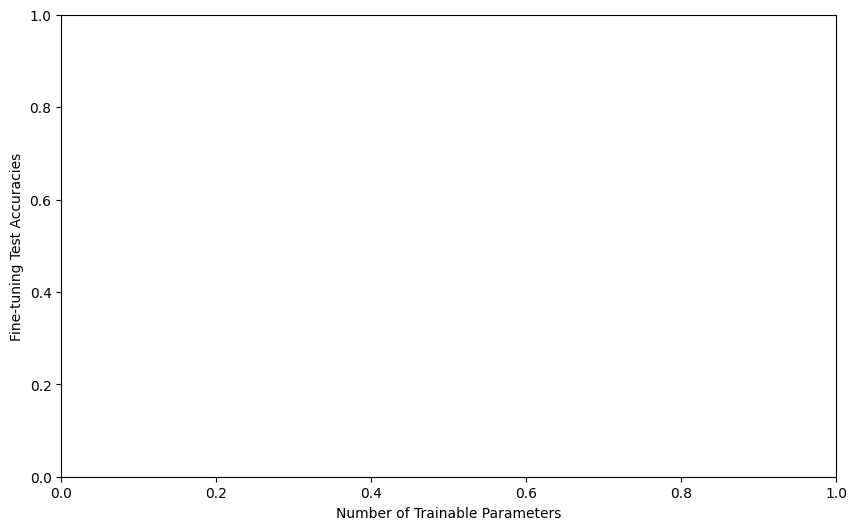

In [88]:
# Define baseline parameters
baseline_parameters = 55100

# Define points for standard fine-tuning
standard_finetuning_points = {
    'quantized': (accuracy_quantized_standard_finetuning, elapsed_time_quantized_standard_finetuning),
    'inverted': (accuracy_inverted_standard_finetuning, elapsed_time_inverted_standard_finetuning),
    'inverse_color': (accuracy_inverse_color_standard_finetuning, elapsed_time_inverse_color_standard_finetuning)
}

# Define colors for each version
colors = {'q': 'blue', 'i': 'green', 'c': 'red'}

# Plot 1st graph: Fine-tuning test accuracies vs number of trainable parameters
plt.figure(figsize=(10, 6))
plt.xlabel('Number of Trainable Parameters')
plt.ylabel('Fine-tuning Test Accuracies')

for version, results in results_dict.items():
    version_results = results[f'version_results_{version}']
    x_values = [parameter_dict[rank] for rank in version_results.keys()]
    y_values = [result['Accuracy'] for result in version_results.values()]
    plt.plot(x_values, y_values, marker='o', linestyle='-', color=colors[version], label=f'Version {version.upper()}')

# Plot standard fine-tuning points
for version, (accuracy, _) in standard_finetuning_points.items():
    plt.scatter(baseline_parameters, accuracy, color=colors[version], label=f'{version.capitalize()} Standard Fine-tuning')

# Plot points for accuracy_quantized_standard_finetuning, accuracy_inverted_standard_finetuning,
# accuracy_inverse_color_standard_finetuning
for version, accuracy in standard_finetuning_points.items():
    plt.scatter(baseline_parameters, accuracy, color=colors[version])

plt.legend()
plt.grid(True)
plt.title('Fine-tuning Test Accuracies vs Number of Trainable Parameters')
plt.show()

# Plot 2nd graph: Elapsed time vs number of trainable parameters
plt.figure(figsize=(10, 6))
plt.xlabel('Number of Trainable Parameters')
plt.ylabel('Elapsed Time (seconds)')

for version, results in results_dict.items():
    version_results = results[f'version_results_{version}']
    x_values = [parameter_dict[rank] for rank in version_results.keys()]
    y_values = [result['Time'] for result in version_results.values()]
    plt.plot(x_values, y_values, marker='o', linestyle='-', color=colors[version], label=f'Version {version.upper()}')

# Plot standard fine-tuning points
for version, (_, elapsed_time) in standard_finetuning_points.items():
    plt.scatter(baseline_parameters, elapsed_time, color=colors[version], label=f'{version.capitalize()} Standard Fine-tuning')

# Plot points for elapsed_time_quantized_standard_finetuning, elapsed_time_inverted_standard_finetuning,
# elapsed_time_inverse_color_standard_finetuning
for version, elapsed_time in standard_finetuning_points.items():
    plt.scatter(baseline_parameters, elapsed_time, color=colors[version])

plt.legend()
plt.grid(True)
plt.title('Elapsed Time vs Number of Trainable Parameters')
plt.show()


## Measure rank of difference matrices

In [92]:
import numpy as np

# measure rank of a matrix
def rank(A, tol=1e-4):
    if tol is None:
        tol = max(A.shape) * np.finfo(float).eps
    u, s, vh = np.linalg.svd(A)
    return len([x for x in s if x > tol])

In [90]:
# measure rank of difference matrices
m1 = model.l1.weight.detach().cpu().numpy() - model_quantized.l1.weight.detach().cpu().numpy()
print(rank(m1), m1.shape)
m2 = model.l2.weight.detach().cpu().numpy() - model_quantized.l2.weight.detach().cpu().numpy()
print(rank(m2), m2.shape)
m3 = model.l3.weight.detach().cpu().numpy() - model_quantized.l3.weight.detach().cpu().numpy()
print(rank(m3), m3.shape)

512 (512, 784)
512 (512, 512)
10 (10, 512)


In [93]:
# measure rank of difference matrices
m1 = model.l1.weight.detach().cpu().numpy() - model_inverted.l1.weight.detach().cpu().numpy()
print(rank(m1), m1.shape)
m2 = model.l2.weight.detach().cpu().numpy() - model_inverted.l2.weight.detach().cpu().numpy()
print(rank(m2), m2.shape)
m3 = model.l3.weight.detach().cpu().numpy() - model_inverted.l3.weight.detach().cpu().numpy()
print(rank(m3), m3.shape)

512 (512, 784)
511 (512, 512)
10 (10, 512)
